# Imports and data loading

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [ ]:
#tomado de https://www.kaggle.com/code/wailinnoo/intrusion-detection-system-using-kdd99-dataset
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
pd_data_frame = pd.read_csv(path, header=None)

# The CSV file has no column heads, so add them
pd_data_frame.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

#describe the dataset
#transform nominal features using a one hot vector encoding
pd_data_frame.describe()

# Determinar si se puede usar GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch
print(f"Usando dispositivo: {device}")


2144903/2144903 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
/root/.keras/datasets/kddcup.data_10_percent.gz
Usando dispositivo: cuda


# Preprocessing and  Dummy encoding transformation

Attacks fall into four main categories:






1.   DOS: denial-of-service, e.g. syn flood;
2.   R2L: unauthorized access from a remote machine, e.g. guessing password;

3. U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;

4. probing: surveillance and other probing, e.g., port scanning.


It is important to note that the test data is not from the same probability distribution as the training data, and it includes specific attack types not in the training data.  This makes the task more realistic.  Some intrusion experts believe that most novel attacks are variants of known attacks and the "signature" of known attacks can be sufficient to catch novel variants.  The datasets contain a total of 24 training attack types, with an additional 14 types in the test data only.

Neptune is the most frequent attack in the dataset, consisting in a type of denial-of-service (DoS) attack overwhelming systems with SYN requests (ynchronize request, is a type of network packet used in the TCP handshake to initiate a connection between a client and a server).

**In this work we will focus in the detection of backdrop attacks**.

In [ ]:
# For now, just drop NA's (rows with missing values), in case there are
pd_data_frame.dropna(inplace=True,axis=1)

# Checkng for DUPLICATE values
pd_data_frame.drop_duplicates(keep='first', inplace = True)
print(pd_data_frame.describe())



            duration     src_bytes     dst_bytes           land  \
count  145586.000000  1.455860e+05  1.455860e+05  145586.000000   
mean      132.025181  7.995700e+03  2.859780e+03       0.000137   
std      1224.157053  1.820383e+06  6.080979e+04       0.011720   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000000  0.000000e+00  0.000000e+00       0.000000   
50%         0.000000  1.470000e+02  1.050000e+02       0.000000   
75%         0.000000  2.880000e+02  1.164750e+03       0.000000   
max     58329.000000  6.933756e+08  5.155468e+06       1.000000   

       wrong_fragment         urgent            hot  num_failed_logins  \
count   145586.000000  145586.000000  145586.000000      145586.000000   
mean         0.020201       0.000048       0.100174           0.000515   
std          0.239368       0.010150       1.426798           0.028585   
min          0.000000       0.000000       0.000000           0.000000   
25%          0.000000     

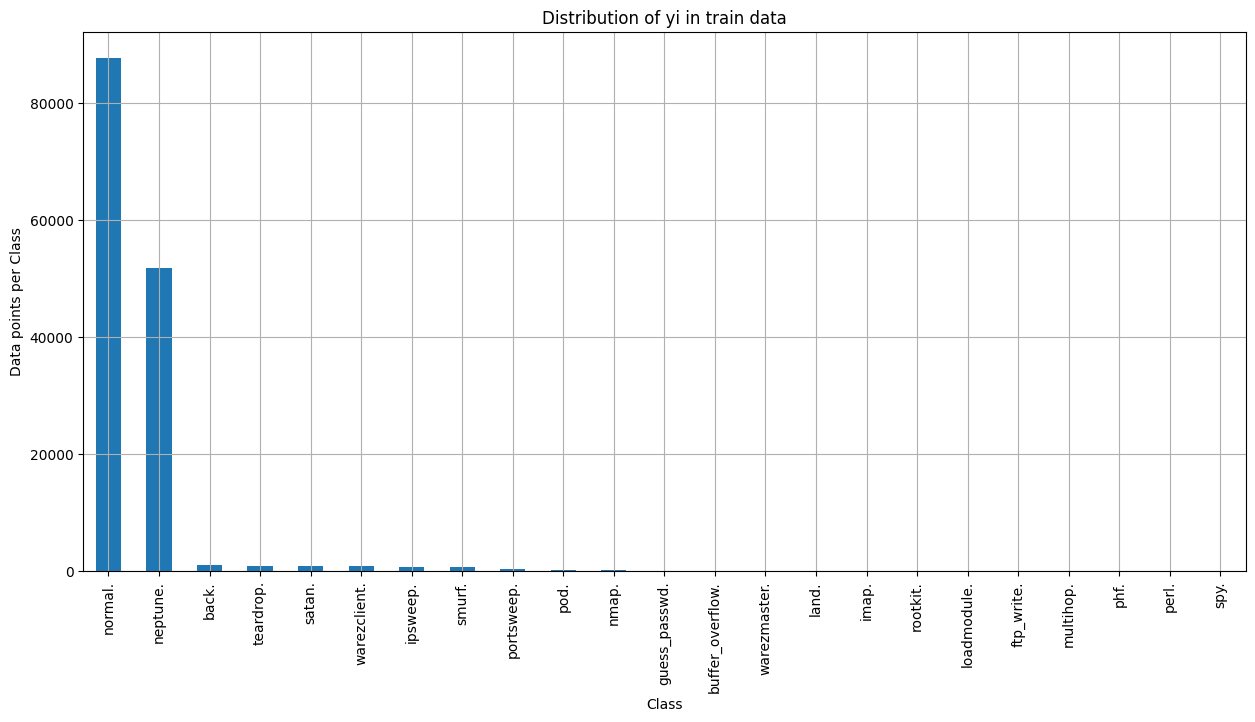

In [ ]:
# distribution of the attack categories (outcome)
# Exploratory data analysis
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = pd_data_frame['outcome'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

#normal and neptune are the more prominent classes

In [ ]:
# Filter the DataFrame to keep only 'normal.' and 'neptune.' outcomes
filtered_df = pd_data_frame[pd_data_frame['outcome'].isin(['normal.', 'back.'])].copy()

# Display the head of the new DataFrame
display(filtered_df.head())

# Display the value counts of the 'outcome' column in the new DataFrame to verify the filtering
display(filtered_df.describe())

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,88800.000000,8.880000e+04,8.880000e+04,88800.000000,88800.0,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,...,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000
mean,186.876059,1.841420e+03,3.768686e+03,0.000011,0.0,0.000034,0.069662,0.000203,0.794887,0.041340,...,139.716318,202.922106,0.854742,0.045972,0.121897,0.025207,0.002346,0.001192,0.056238,0.054262
std,1313.879378,3.623510e+04,3.931359e+04,0.003356,0.0,0.010067,0.919667,0.021747,0.403786,4.236703,...,102.206888,85.696364,0.294697,0.154868,0.259896,0.049351,0.030791,0.016464,0.220121,0.213595
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.930000e+02,2.250000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,34.000000,166.000000,0.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.420000e+02,6.330000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,132.000000,255.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.210000e+02,2.507000e+03,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,0.070000,0.030000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,2.194619e+06,5.134218e+06,1.000000,0.0,3.000000,30.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
list_nominal_features = ["flag", "protocol_type", "service"]

# Apply one-hot encoding to the nominal features
df_encoded = pd.get_dummies(filtered_df, columns=list_nominal_features)

# Convert boolean columns (from one-hot encoding) to integers (0 or 1) in df_encoded
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

# Display the first few rows of the modified DataFrame to verify
print("DataFrame with boolean columns converted to integers:")
display(df_encoded.describe())
print("Columns after nominal attributes encoded: ")
for i in df_encoded.columns:
  print(i)


DataFrame with boolean columns converted to integers:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_red_i,service_shell,service_smtp,service_ssh,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i
count,88800.000000,8.880000e+04,8.880000e+04,88800.000000,88800.0,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,...,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000
mean,186.876059,1.841420e+03,3.768686e+03,0.000011,0.0,0.000034,0.069662,0.000203,0.794887,0.041340,...,0.000011,0.000011,0.108086,0.000011,0.002466,0.000011,0.000023,0.000394,0.000158,0.004977
std,1313.879378,3.623510e+04,3.931359e+04,0.003356,0.0,0.010067,0.919667,0.021747,0.403786,4.236703,...,0.003356,0.003356,0.310490,0.003356,0.049600,0.003356,0.004746,0.019849,0.012555,0.070376
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.930000e+02,2.250000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.420000e+02,6.330000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.210000e+02,2.507000e+03,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,2.194619e+06,5.134218e+06,1.000000,0.0,3.000000,30.000000,4.000000,1.000000,884.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Columns after nominal attributes encoded: 
duration
src_bytes
dst_bytes
land
wrong_fragment
urgent
hot
num_failed_logins
logged_in
num_compromised
root_shell
su_attempted
num_root
num_file_creations
num_shells
num_access_files
num_outbound_cmds
is_host_login
is_guest_login
count
srv_count
serror_rate
srv_serror_rate
rerror_rate
srv_rerror_rate
same_srv_rate
diff_srv_rate
srv_diff_host_rate
dst_host_count
dst_host_srv_count
dst_host_same_srv_rate
dst_host_diff_srv_rate
dst_host_same_src_port_rate
dst_host_srv_diff_host_rate
dst_host_serror_rate
dst_host_srv_serror_rate
dst_host_rerror_rate
dst_host_srv_rerror_rate
outcome
flag_OTH
flag_REJ
flag_RSTO
flag_RSTR
flag_S0
flag_S1
flag_S2
flag_S3
flag_SF
protocol_type_icmp
protocol_type_tcp
protocol_type_udp
service_IRC
service_X11
service_auth
service_domain
service_domain_u
service_eco_i
service_ecr_i
service_finger
service_ftp
service_ftp_data
service_http
service_ntp_u
service_other
service_pop_3
service_private
service_red_i
service_shel

# Data Descriptive Analysis

In [ ]:

#Lets analyze the data of each category, using common statistic moments

# Create a DataFrame for attacks (attack_detected == 1)
df_attacks = df_encoded[df_encoded['outcome'] == 'back.'].copy()

# Create a DataFrame for no attacks (attack_detected == 0)
df_no_attacks = df_encoded[df_encoded['outcome'] == 'normal.'].copy()

# Display the first few rows of each new DataFrame to verify
print("DataFrame with attacks:")
display(df_attacks.describe())

print("\nDataFrame with no attacks:")
display(df_no_attacks.describe())



DataFrame with attacks:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_red_i,service_shell,service_smtp,service_ssh,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i
count,968.000000,968.000000,968.000000,968.0,968.0,968.0,968.000000,968.0,968.0,968.000000,...,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0
mean,0.293388,53666.892562,8129.908058,0.0,0.0,0.0,1.917355,0.0,1.0,0.924587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.660627,4722.463858,919.138524,0.0,0.0,0.0,0.314076,0.0,0.0,0.264193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,13140.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,54540.000000,8314.000000,0.0,0.0,0.0,2.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,54540.000000,8314.000000,0.0,0.0,0.0,2.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,54540.000000,8314.000000,0.0,0.0,0.0,2.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,14.000000,54540.000000,8315.000000,0.0,0.0,0.0,3.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



DataFrame with no attacks:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_red_i,service_shell,service_smtp,service_ssh,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i
count,87832.000000,8.783200e+04,8.783200e+04,87832.000000,87832.0,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,...,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000
mean,188.932394,1.270249e+03,3.720620e+03,0.000011,0.0,0.000034,0.049299,0.000205,0.792627,0.031606,...,0.000011,0.000011,0.109277,0.000011,0.002493,0.000011,0.000023,0.000398,0.000159,0.005032
std,1320.952947,3.601777e+04,3.952684e+04,0.003374,0.0,0.010123,0.903317,0.021867,0.405427,4.258875,...,0.003374,0.003374,0.311988,0.003374,0.049872,0.003374,0.004772,0.019958,0.012624,0.070761
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.920000e+02,1.930000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.400000e+02,6.120000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.190000e+02,2.431000e+03,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,2.194619e+06,5.134218e+06,1.000000,0.0,3.000000,30.000000,4.000000,1.000000,884.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Análisis descriptivo de las características en el conjunto

In [ ]:
def custom_describe(df):
  # Filtrar solo columnas numéricas
  numeric_df = df.select_dtypes(include='number')
  #Convertir a tensor de PyTorch en GPU o CPU
  tensor = torch.tensor(numeric_df.values, dtype=torch.float32, device=device)


  # Calculo de estadísticas
  mean = tensor.mean(dim=0)
  std = tensor.std(dim=0, unbiased=False)

  def skewness(t):
      mean_ = t.mean(dim=0)
      std_ = t.std(dim=0, unbiased=False)
      skew = (((t - mean_)**3).mean(dim=0)) / (std_**3)
      return skew

  def kurtosis(t):
      mean_ = t.mean(dim=0)
      std_ = t.std(dim=0, unbiased=False)
      kurt = (((t - mean_)**4).mean(dim=0)) / (std_**4)
      return kurt - 3  # Fisher kurtosis (como en pandas)

  skew = skewness(tensor)
  kurt = kurtosis(tensor)

  # Convertir resultados a DataFrame (en CPU)
  custom_describe = pd.DataFrame({
      'mean': mean.cpu().numpy(),
      'std': std.cpu().numpy(),
      'skew': skew.cpu().numpy(),
      'kurtosis': kurt.cpu().numpy()
  }, index=numeric_df.columns)

  # Mostrar resumen
  print(custom_describe)
  return custom_describe

print("Resumen de estadísticas:")
print("Attacks")
describe_attacks = custom_describe(df_attacks)
print("No attacks")
describe_no_attacks = custom_describe(df_no_attacks)



Resumen de estadísticas:
Attacks
                        mean          std      skew   kurtosis
duration            0.293388     1.659769  6.211482  39.397385
src_bytes       53666.890625  4720.023926 -6.385117  42.711460
dst_bytes        8129.907715   918.663696 -5.925030  35.952244
land                0.000000     0.000000       NaN        NaN
wrong_fragment      0.000000     0.000000       NaN        NaN
...                      ...          ...       ...        ...
service_tftp_u      0.000000     0.000000       NaN        NaN
service_tim_i       0.000000     0.000000       NaN        NaN
service_time        0.000000     0.000000       NaN        NaN
service_urh_i       0.000000     0.000000       NaN        NaN
service_urp_i       0.000000     0.000000       NaN        NaN

[75 rows x 4 columns]
No attacks
                       mean           std        skew      kurtosis
duration         188.932388   1320.945435   10.840581    164.946335
src_bytes       1270.249146  36017.558594

 Por cada característica, grafique el histograma para la categoría ataque (backdoor) y normal, y compute la distancia de Jensen-Shannon entre ambas aproximaciones de las densidades. Realice los gráficos para facilitar la comparación, y analice los resultados.

Jensen-Shannon Distance between normal and backdoor outcomes for each feature:


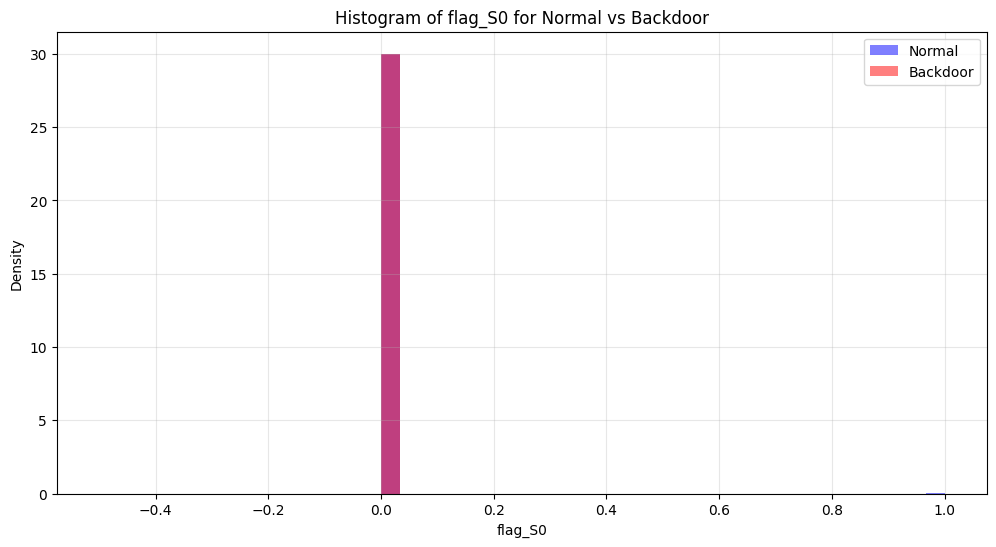

flag_S0: JS Divergence = 0.014187


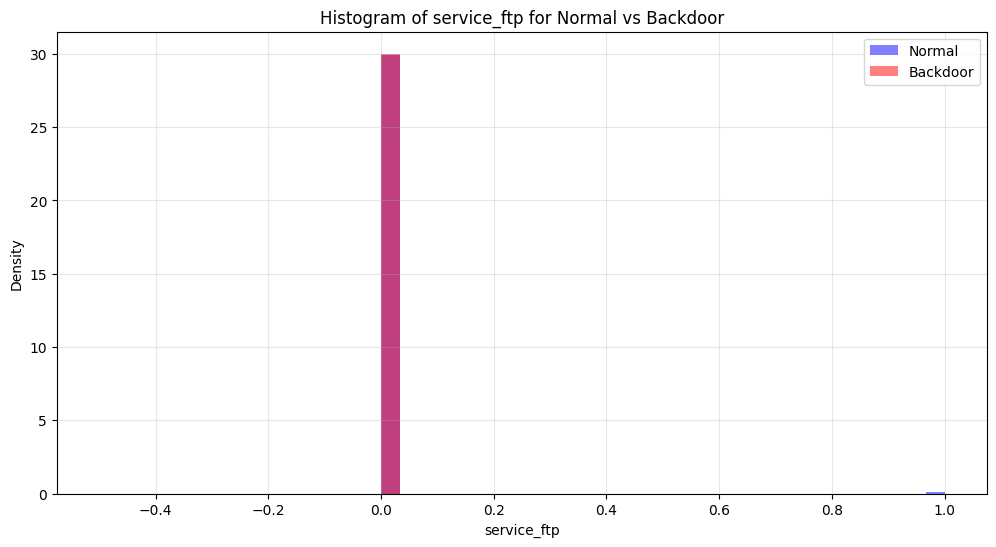

service_ftp: JS Divergence = 0.038394


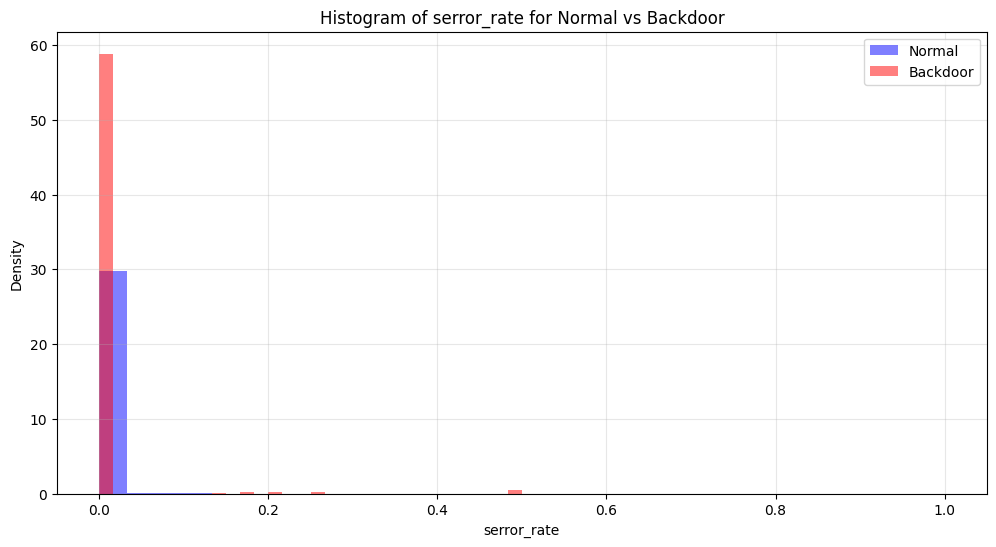

serror_rate: JS Divergence = 0.071459


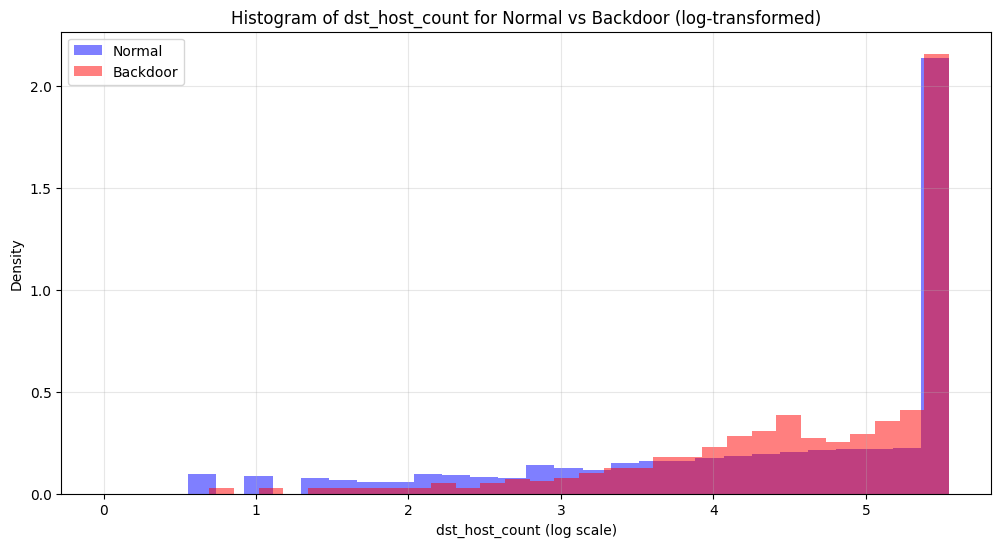

dst_host_count: JS Divergence = 0.167989


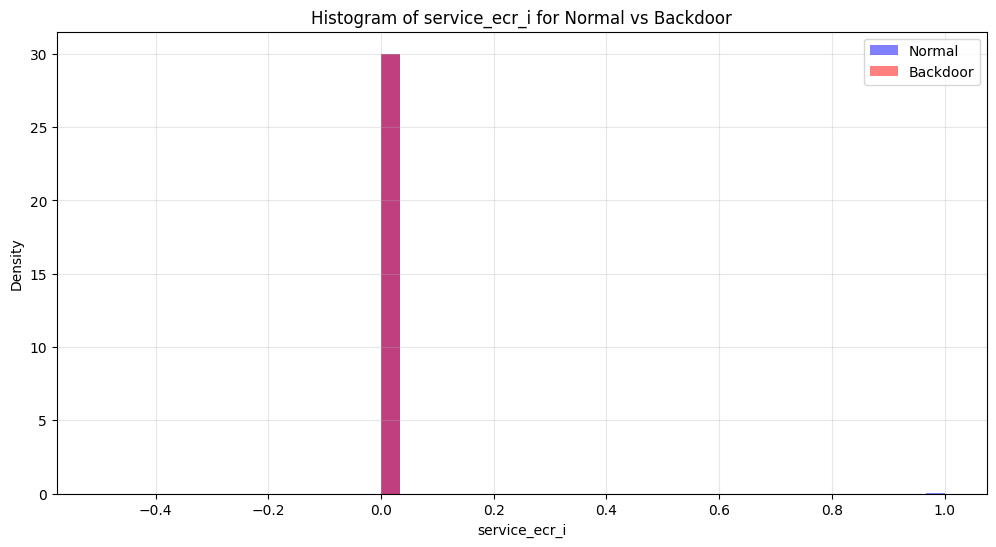

service_ecr_i: JS Divergence = 0.026437


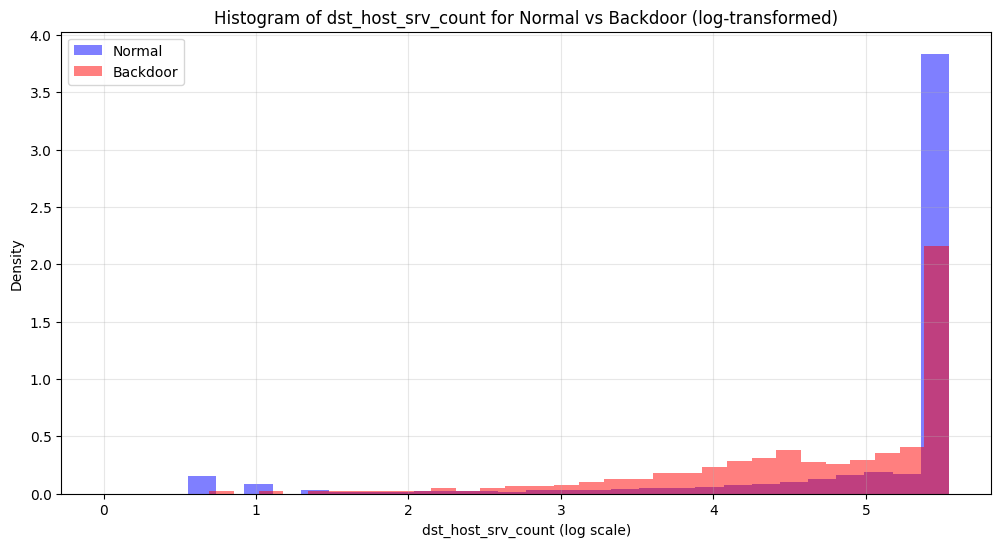

dst_host_srv_count: JS Divergence = 0.312679


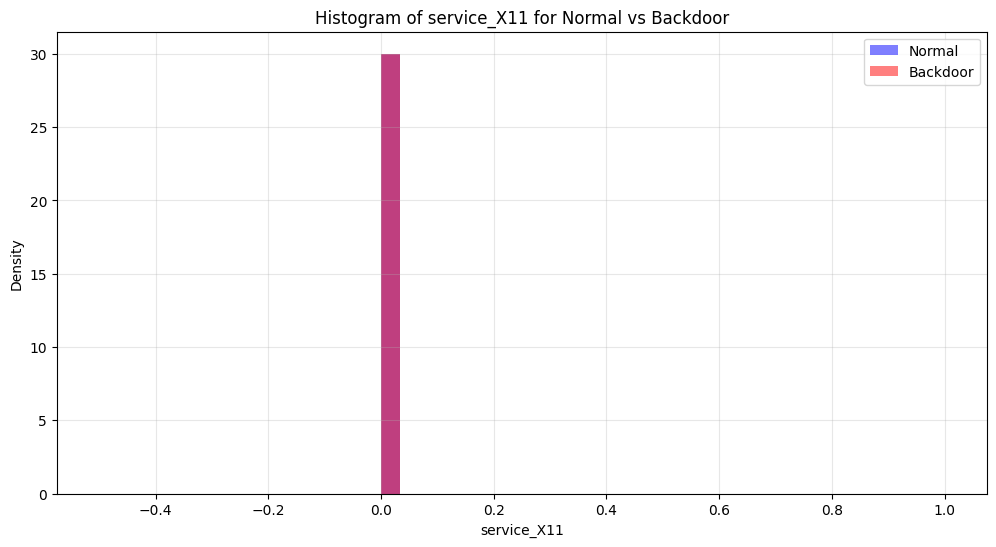

service_X11: JS Divergence = 0.005959


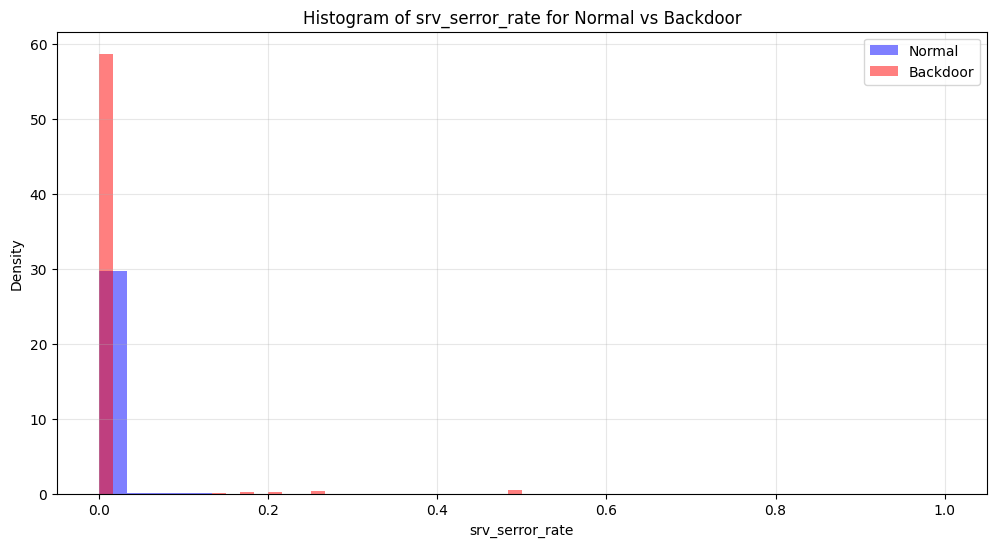

srv_serror_rate: JS Divergence = 0.085204


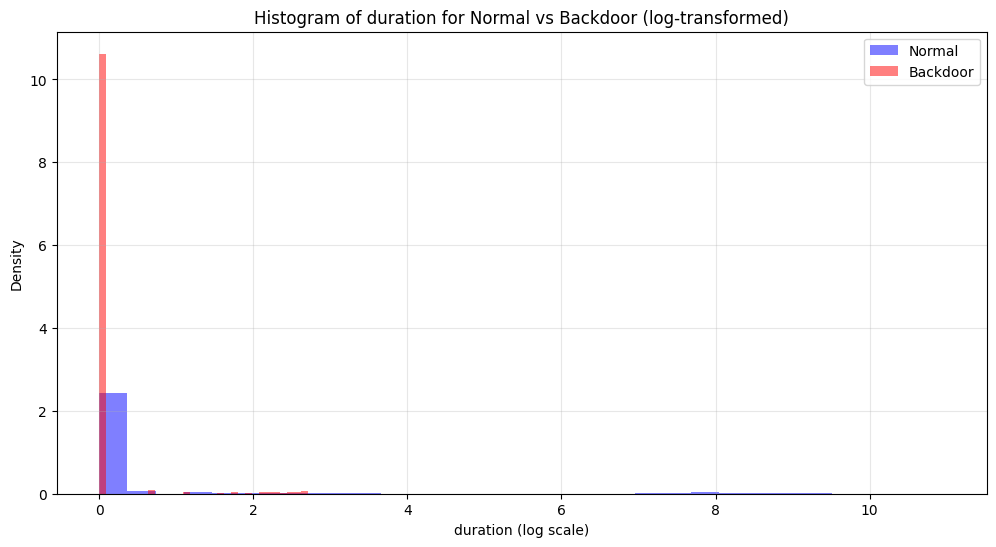

duration: JS Divergence = 0.114801


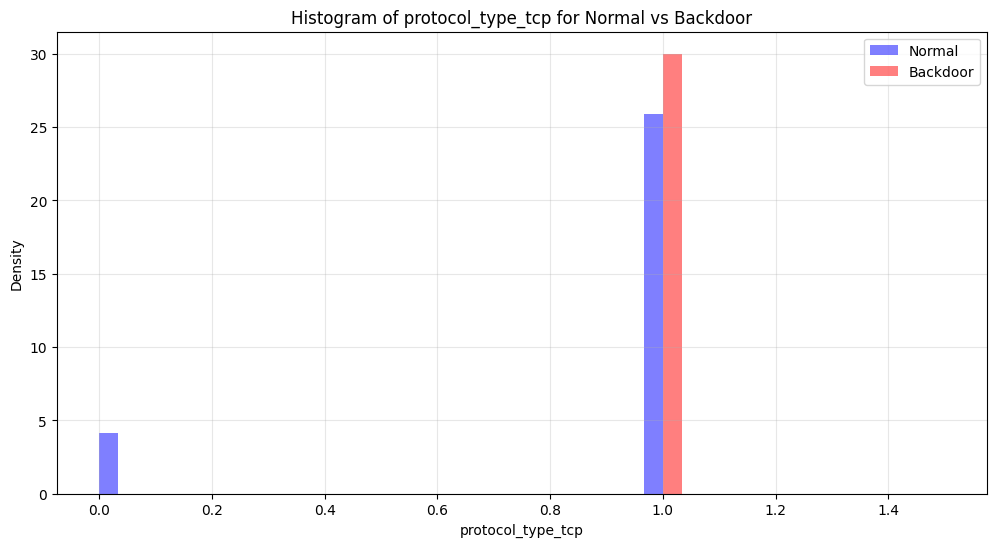

protocol_type_tcp: JS Divergence = 0.223708


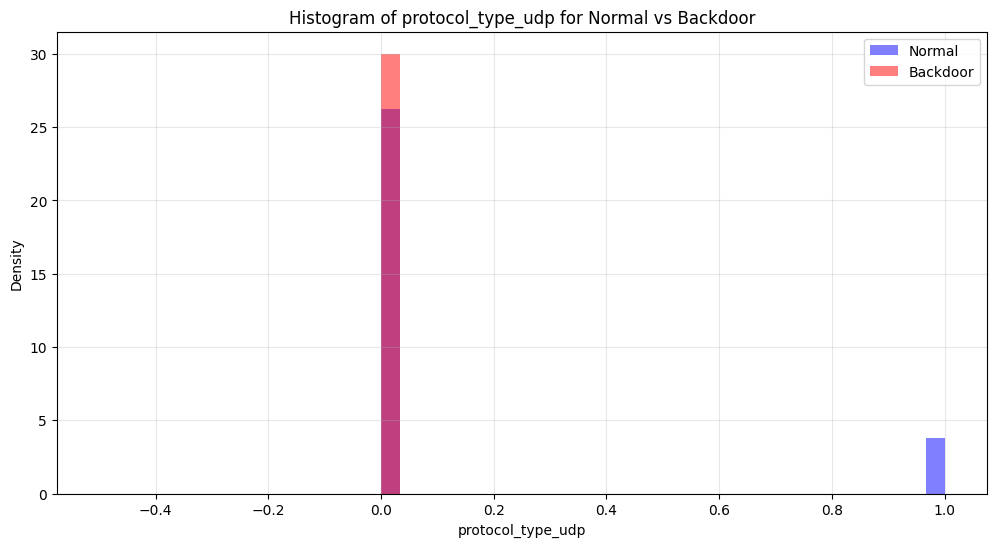

protocol_type_udp: JS Divergence = 0.214833


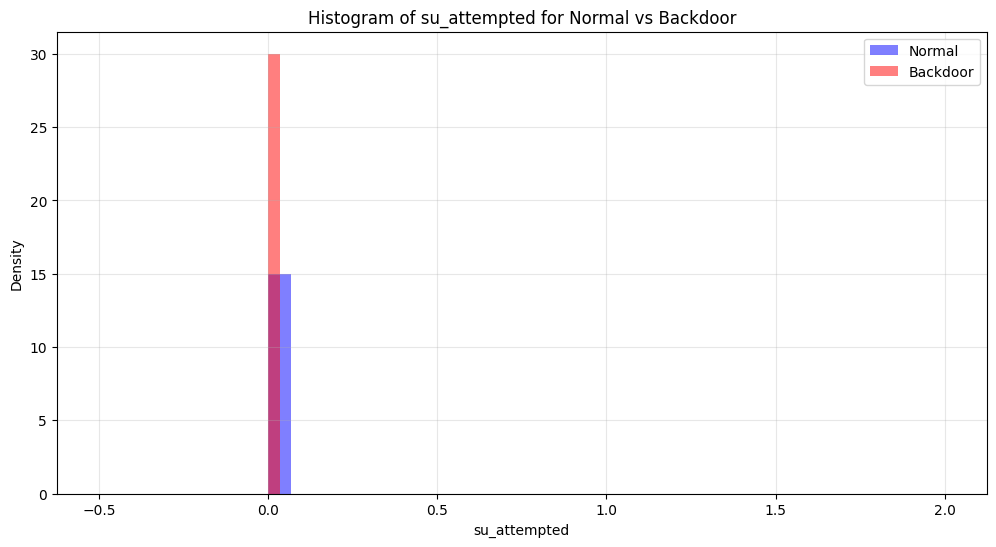

su_attempted: JS Divergence = 0.004659


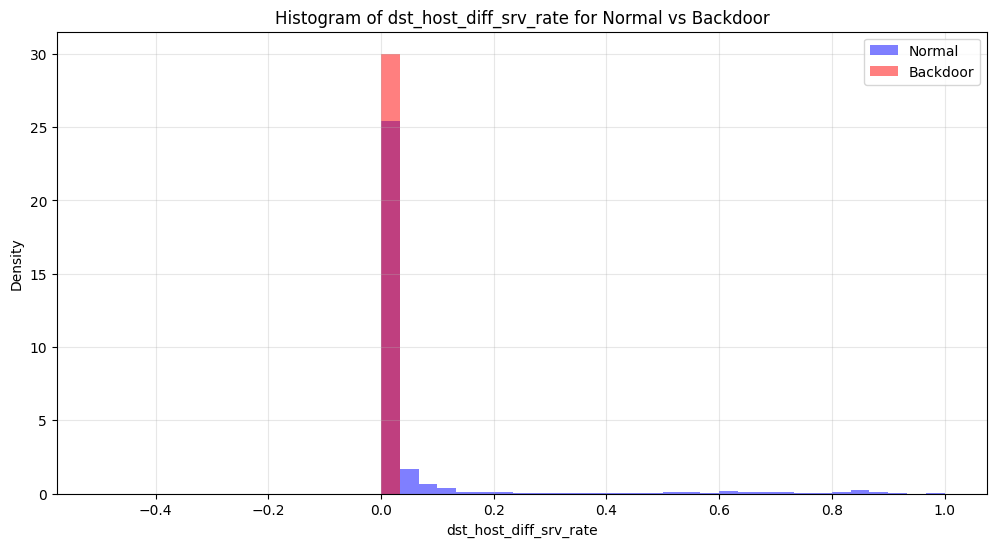

dst_host_diff_srv_rate: JS Divergence = 3.568356


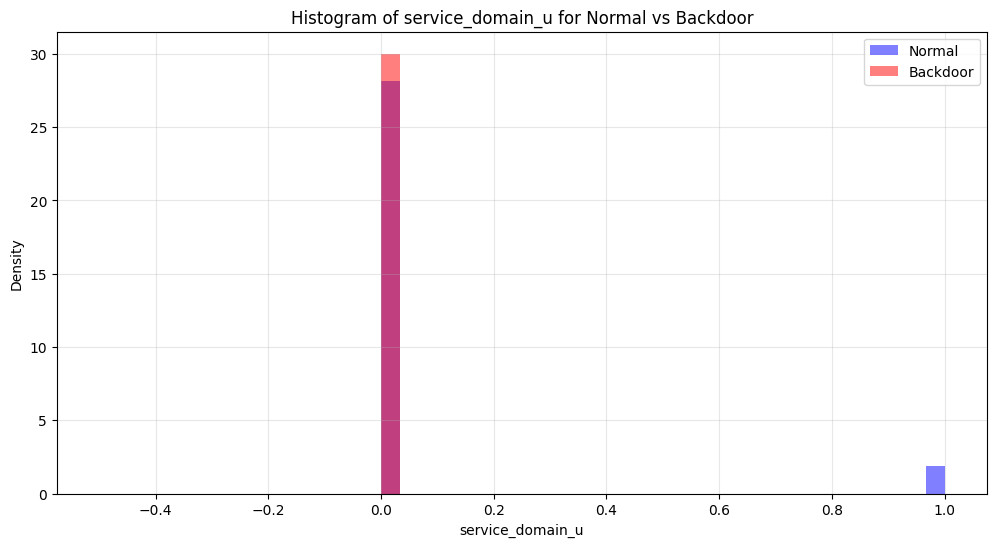

service_domain_u: JS Divergence = 0.147967


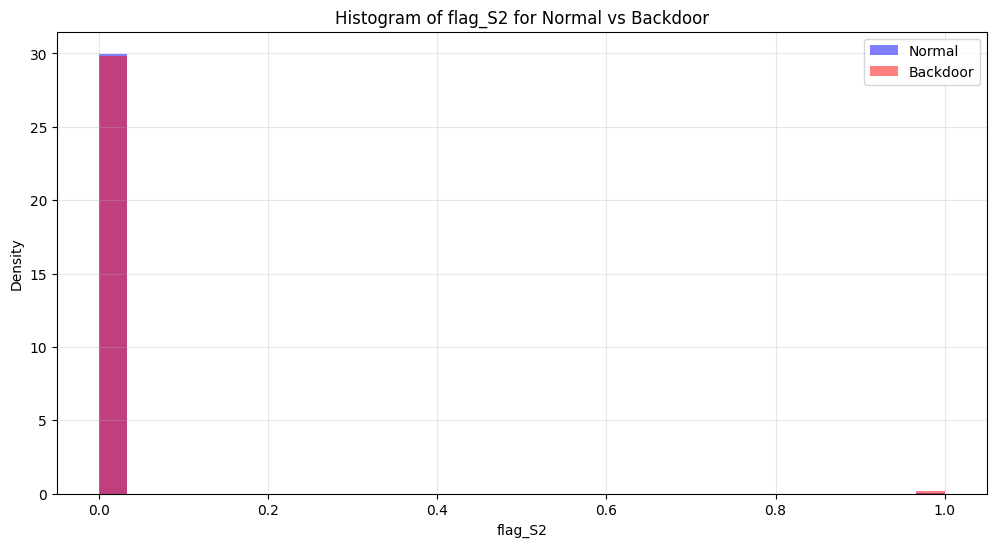

flag_S2: JS Divergence = 0.037999


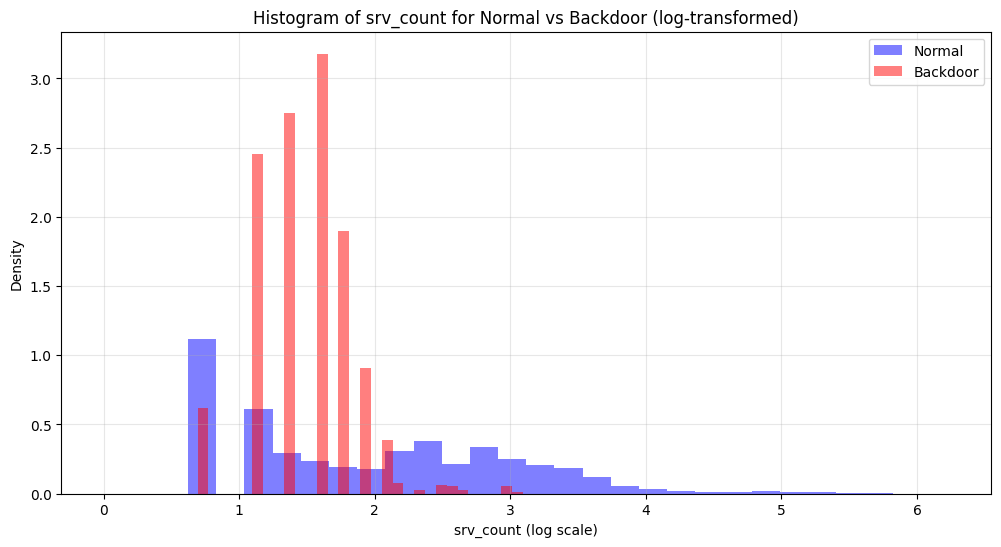

srv_count: JS Divergence = 0.465054


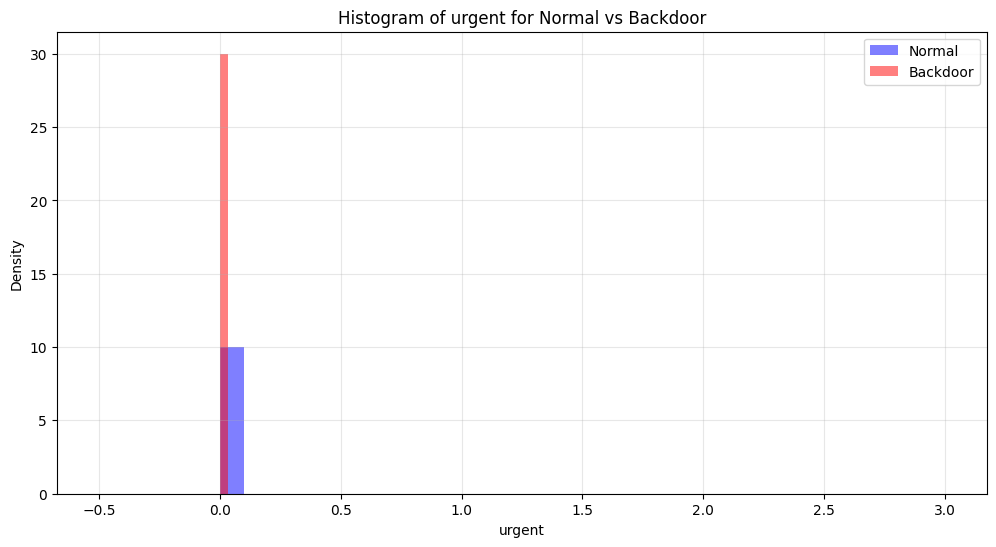

urgent: JS Divergence = 0.001147


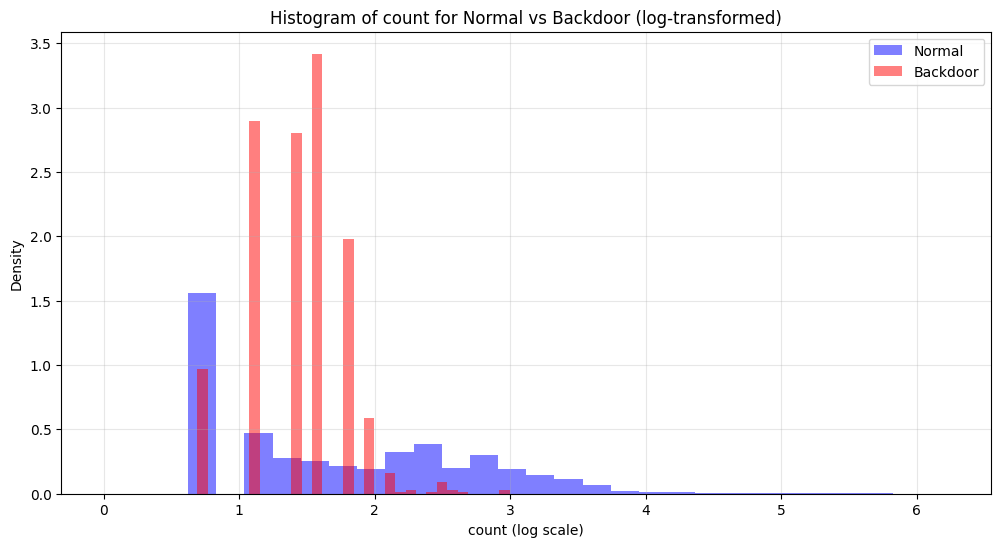

count: JS Divergence = 0.479887


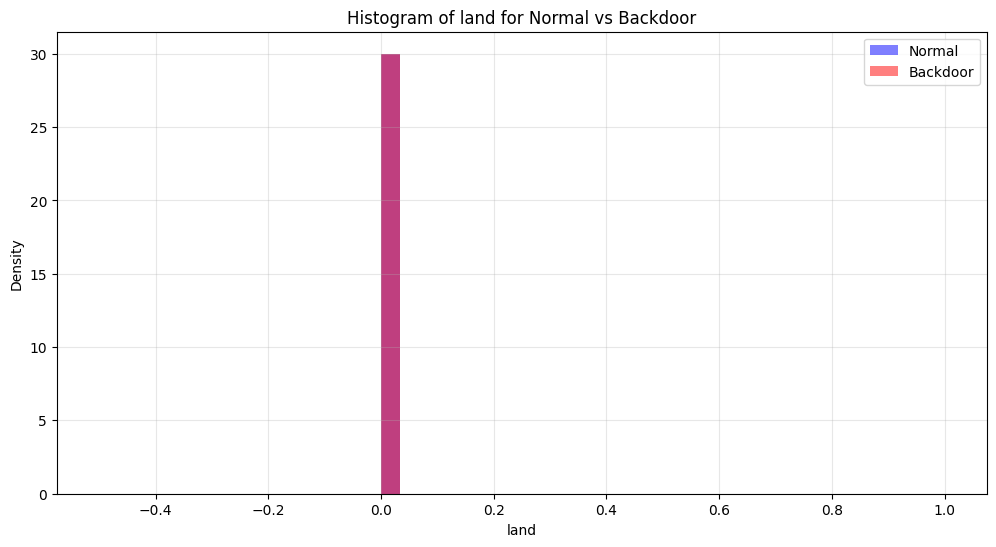

land: JS Divergence = 0.001986


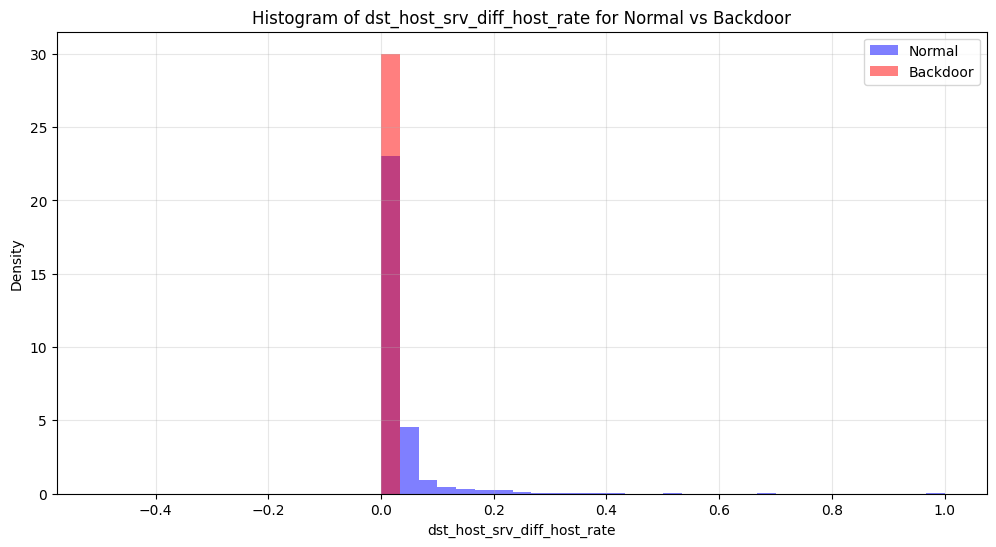

dst_host_srv_diff_host_rate: JS Divergence = 3.575825


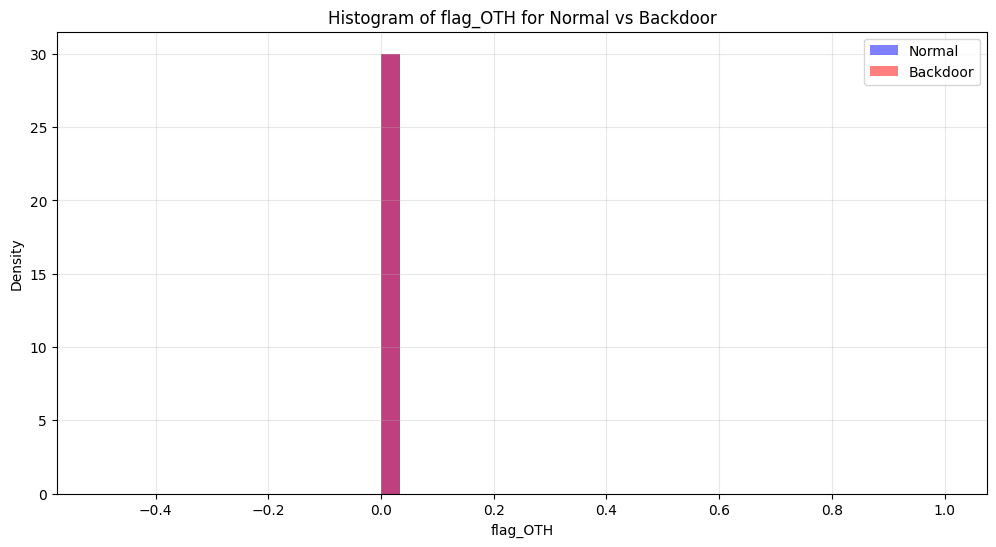

flag_OTH: JS Divergence = 0.001986


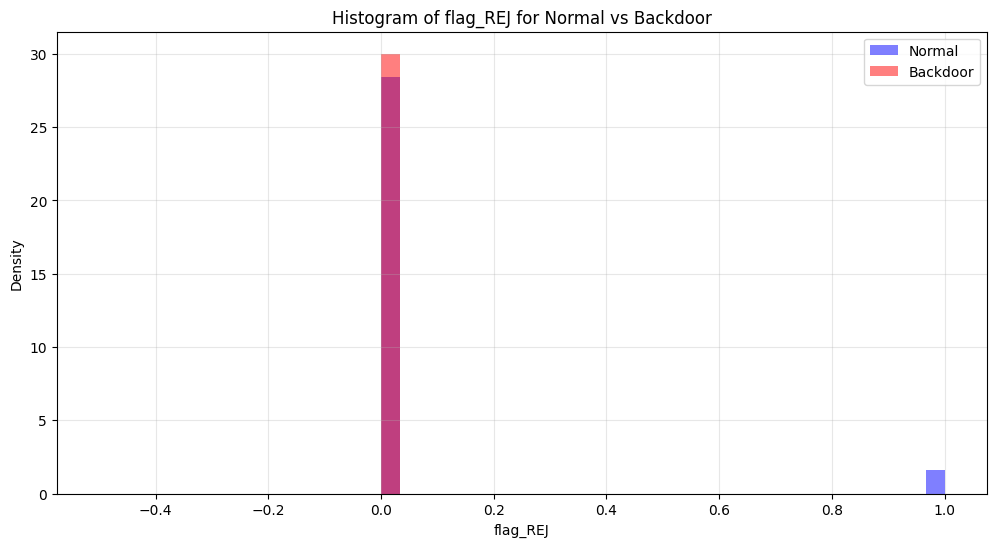

flag_REJ: JS Divergence = 0.136853


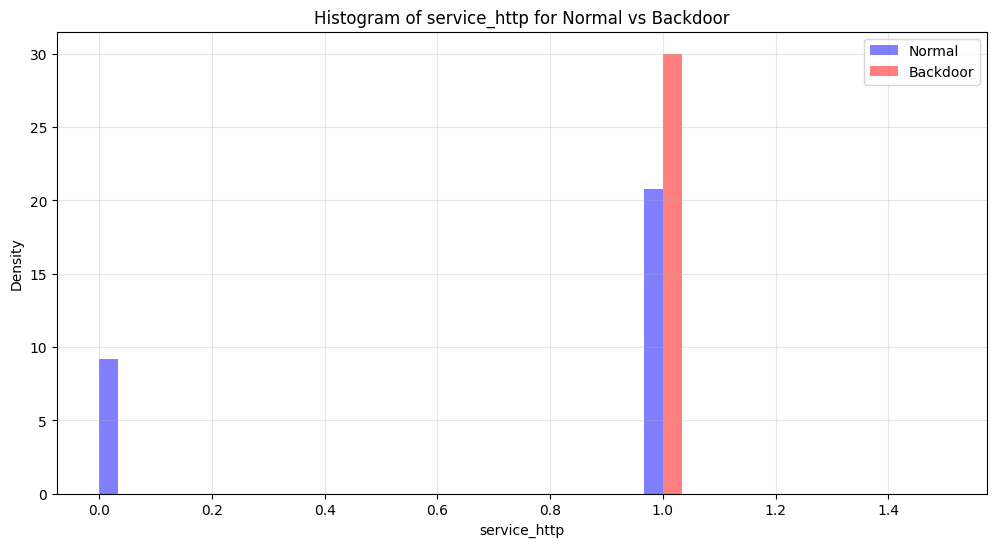

service_http: JS Divergence = 0.346864


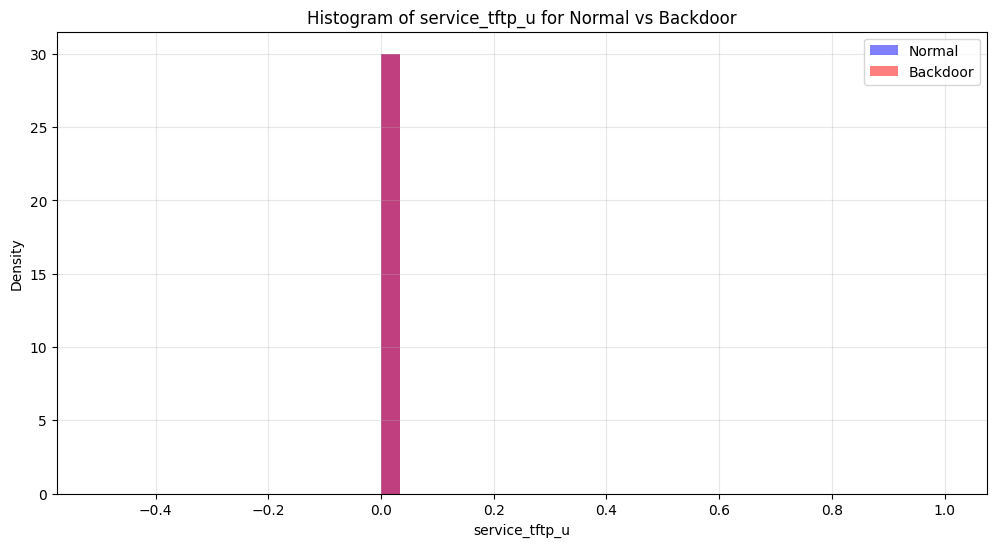

service_tftp_u: JS Divergence = 0.001986


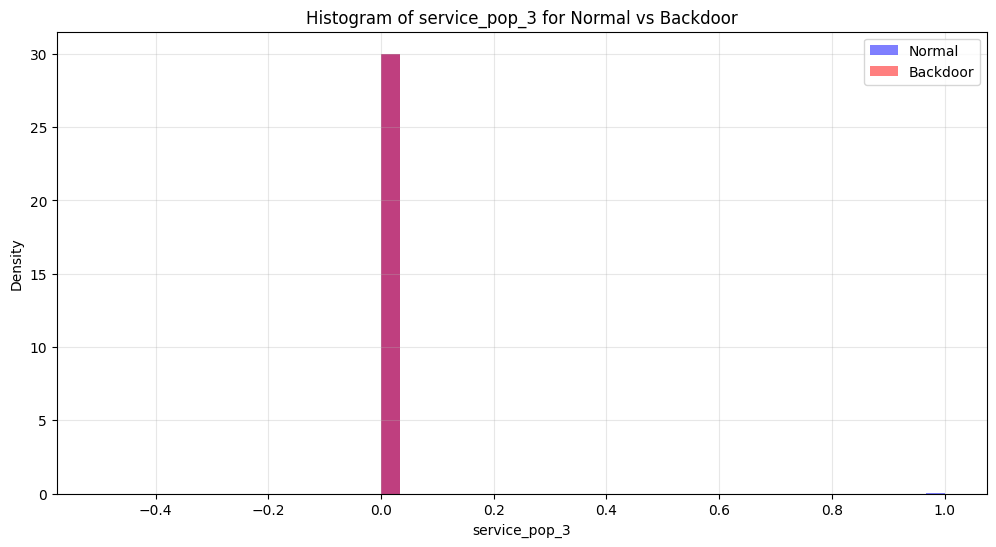

service_pop_3: JS Divergence = 0.017546


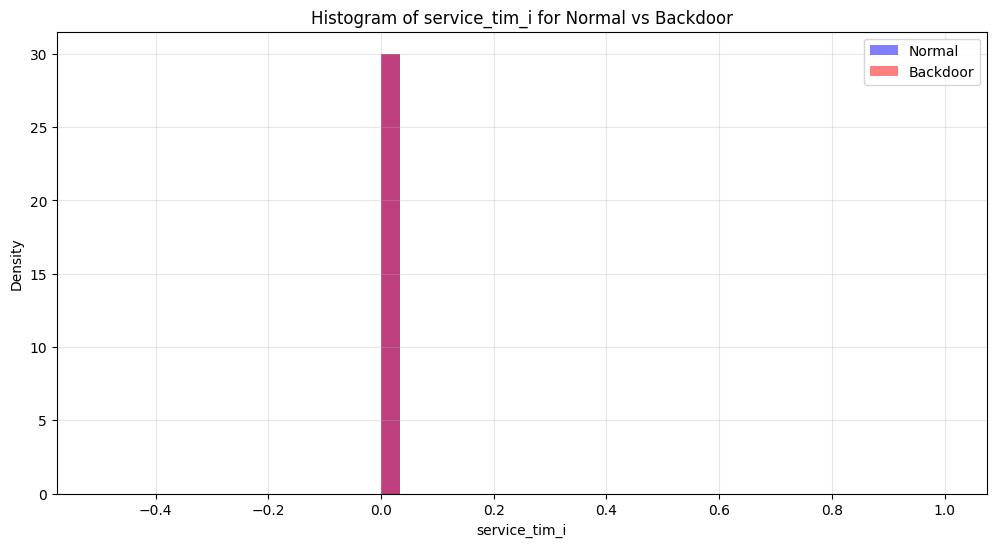

service_tim_i: JS Divergence = 0.002809


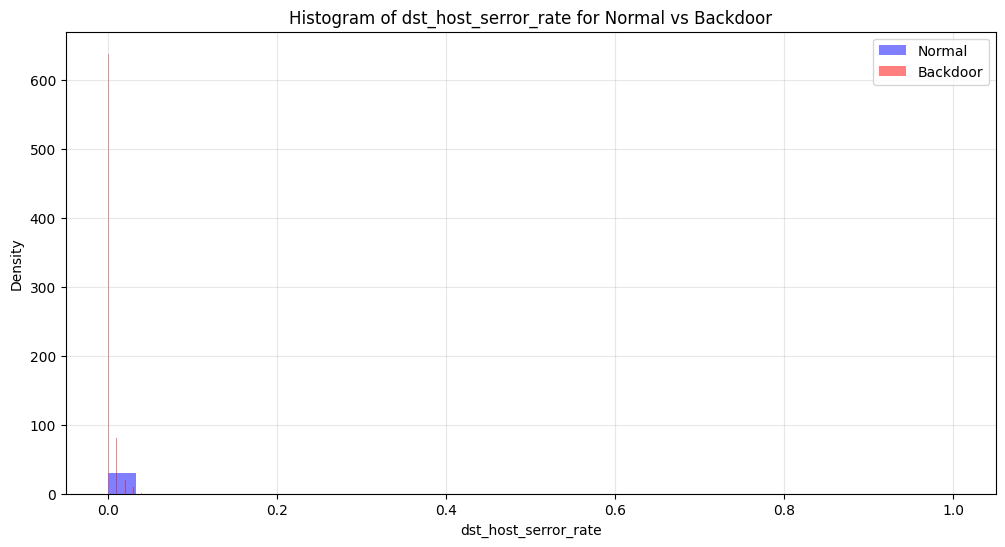

dst_host_serror_rate: JS Divergence = 0.121639


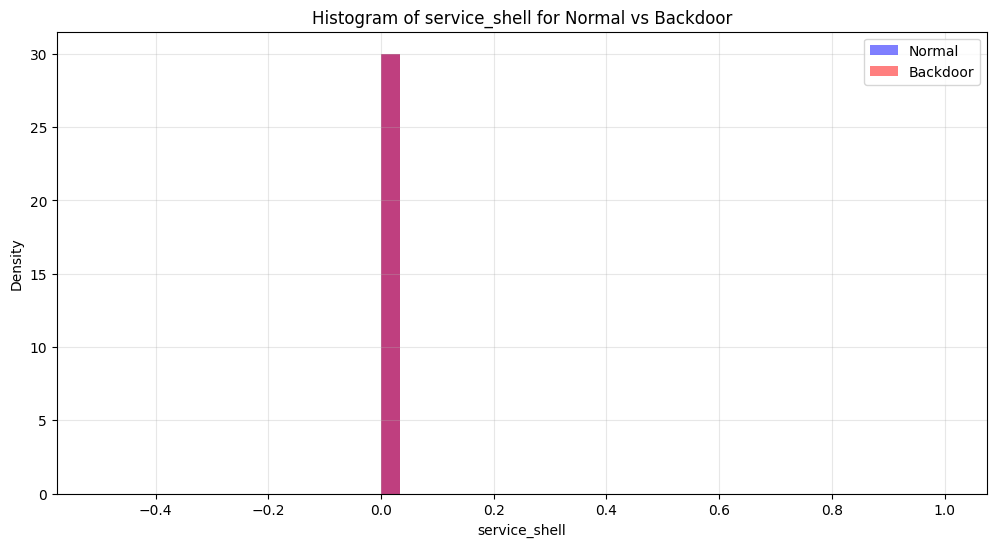

service_shell: JS Divergence = 0.001986


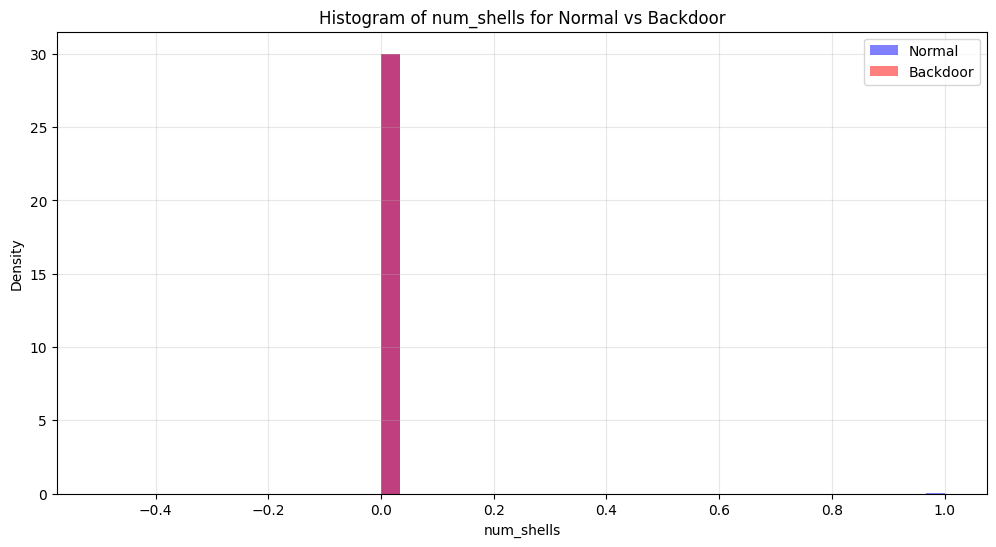

num_shells: JS Divergence = 0.013027


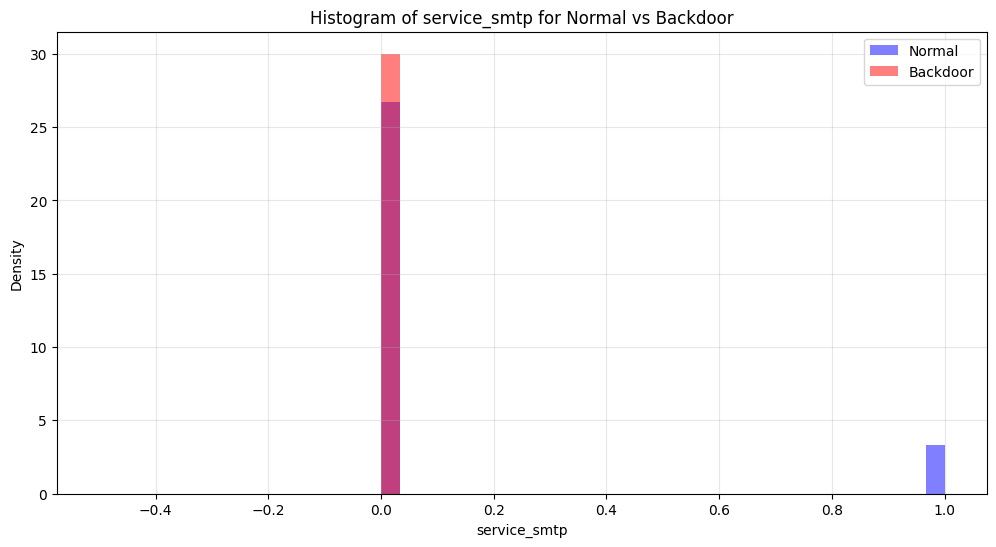

service_smtp: JS Divergence = 0.198626


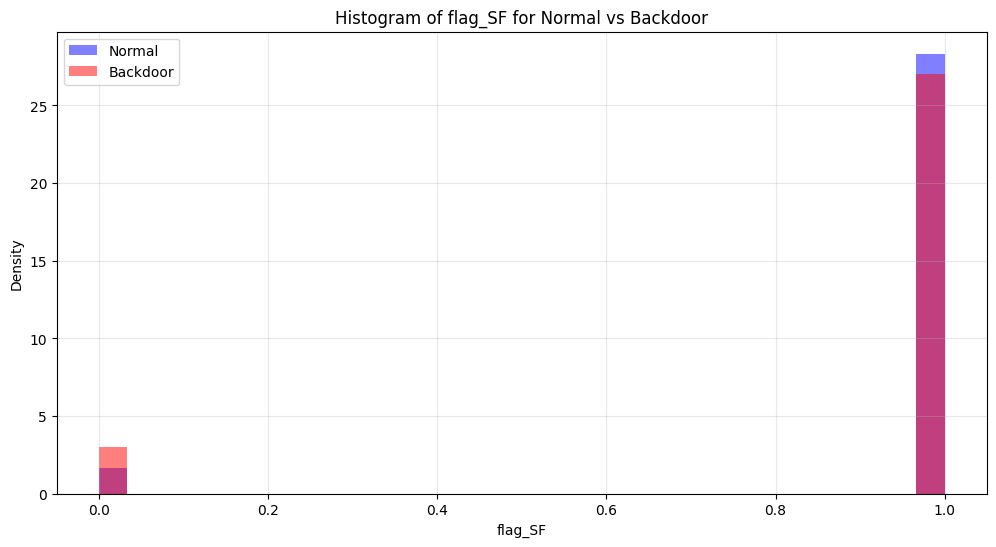

flag_SF: JS Divergence = 0.059250


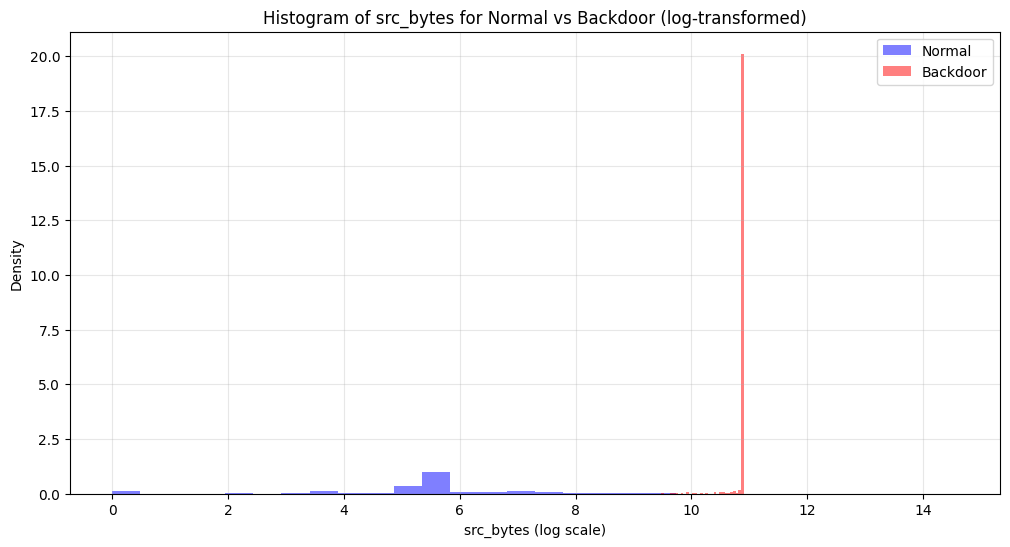

src_bytes: JS Divergence = 0.857847


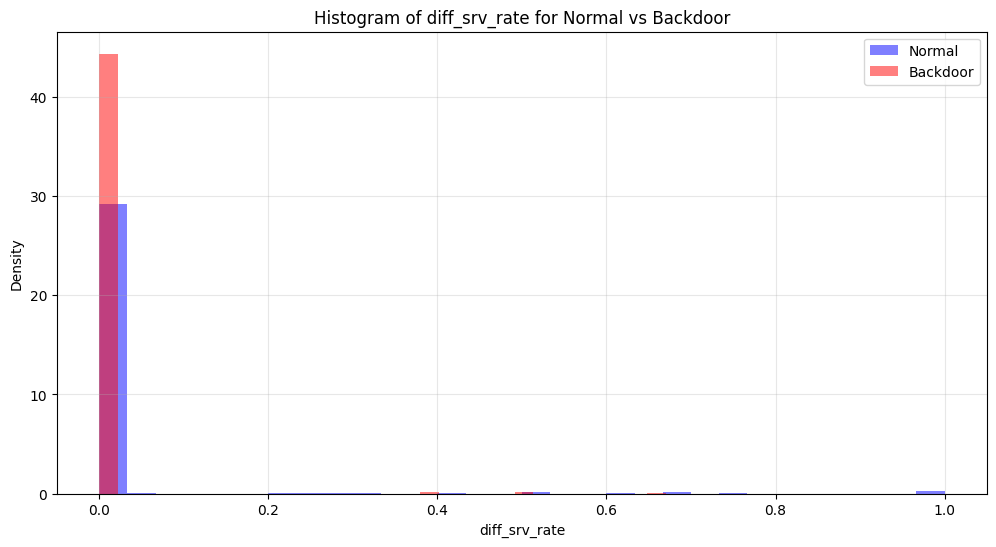

diff_srv_rate: JS Divergence = 0.133295


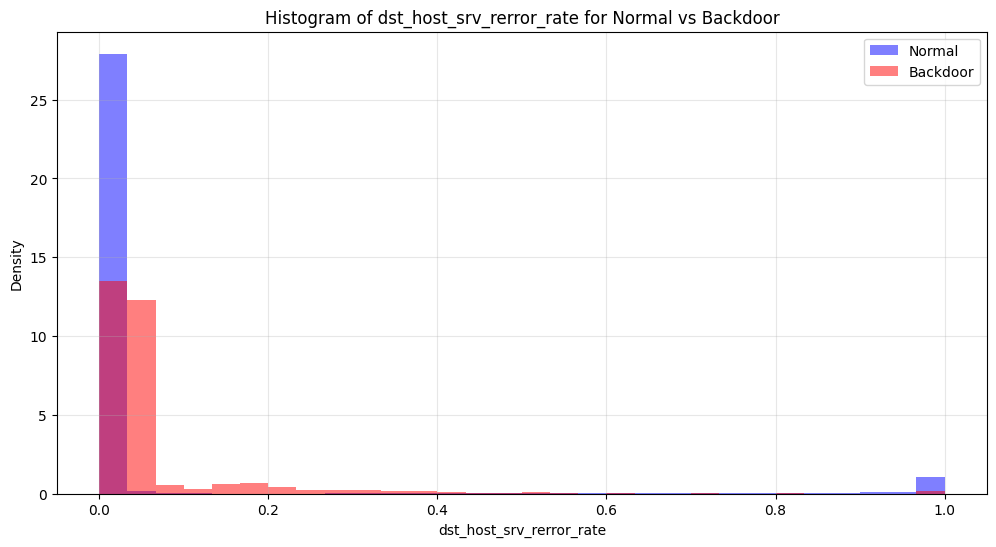

dst_host_srv_rerror_rate: JS Divergence = 0.466678


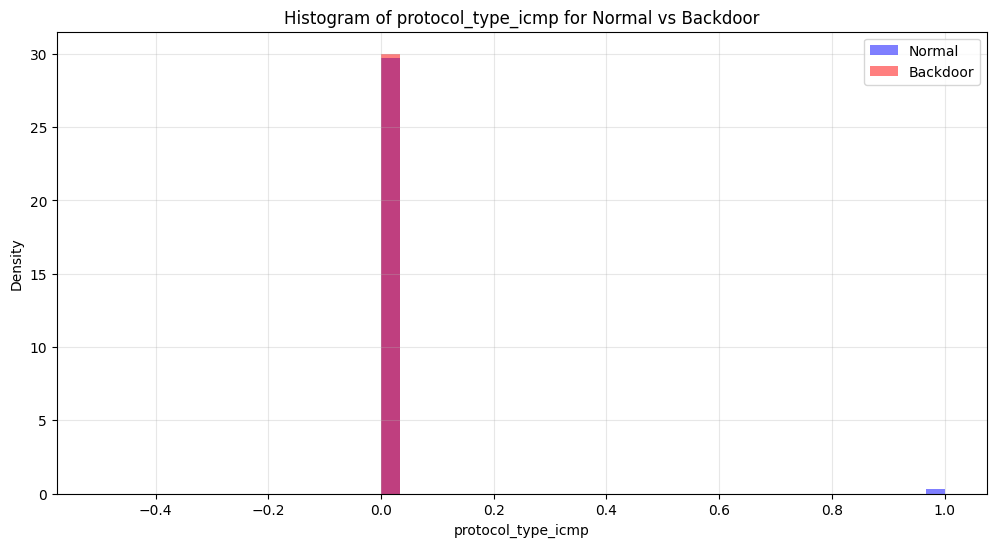

protocol_type_icmp: JS Divergence = 0.059436


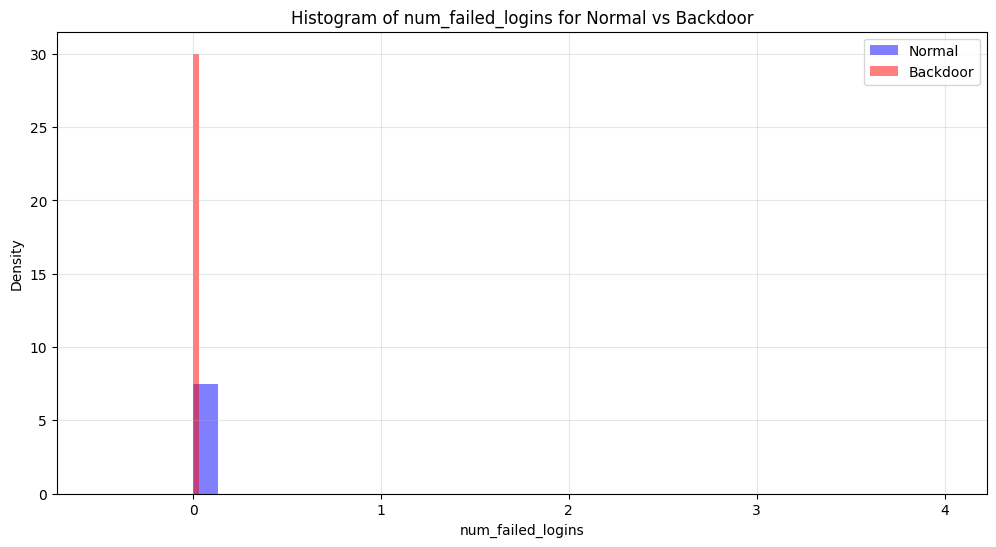

num_failed_logins: JS Divergence = 0.003141


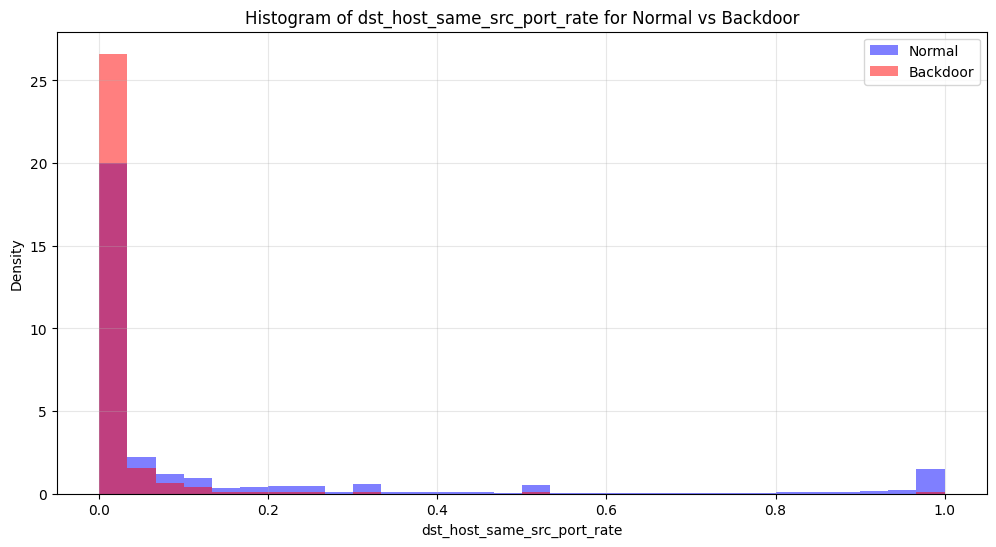

dst_host_same_src_port_rate: JS Divergence = 0.225873


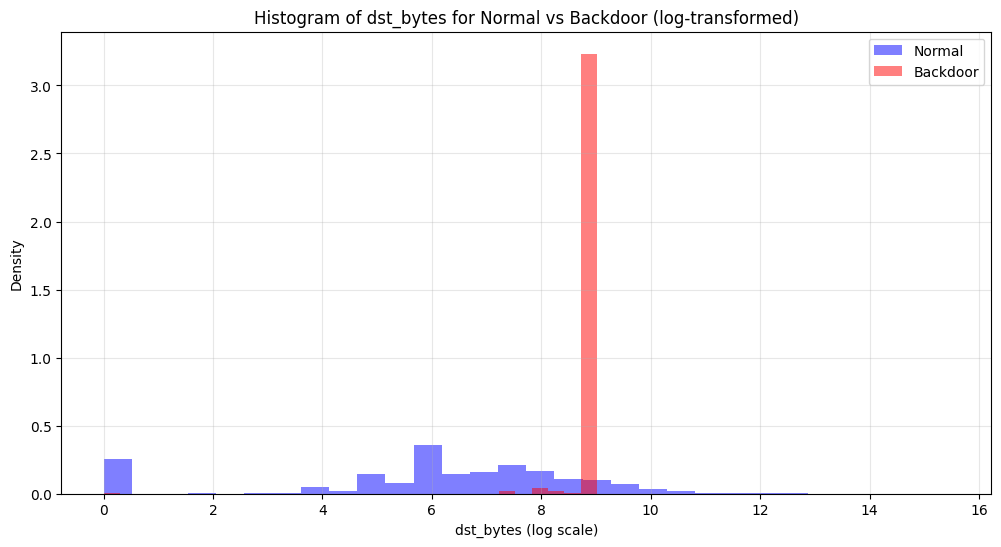

dst_bytes: JS Divergence = 0.773063


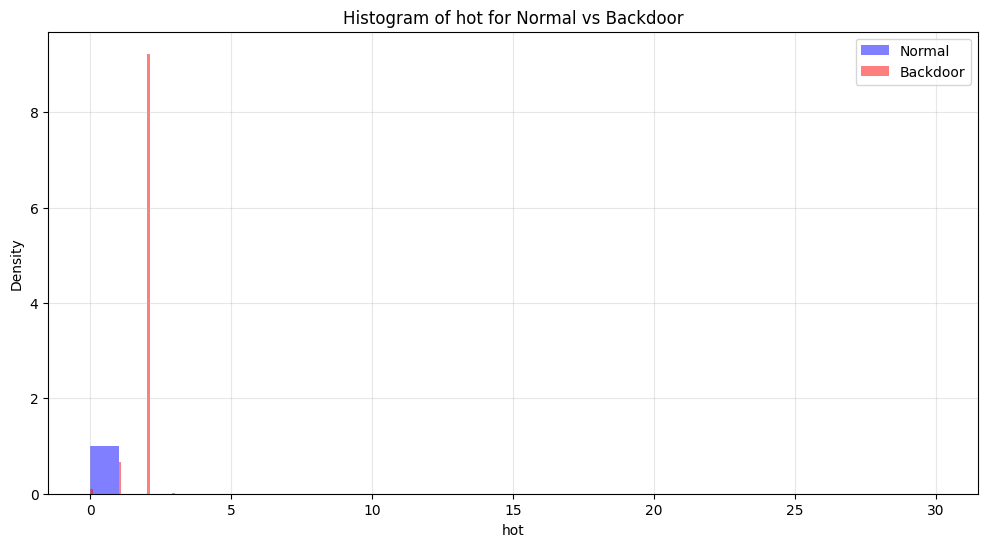

hot: JS Divergence = 0.813192


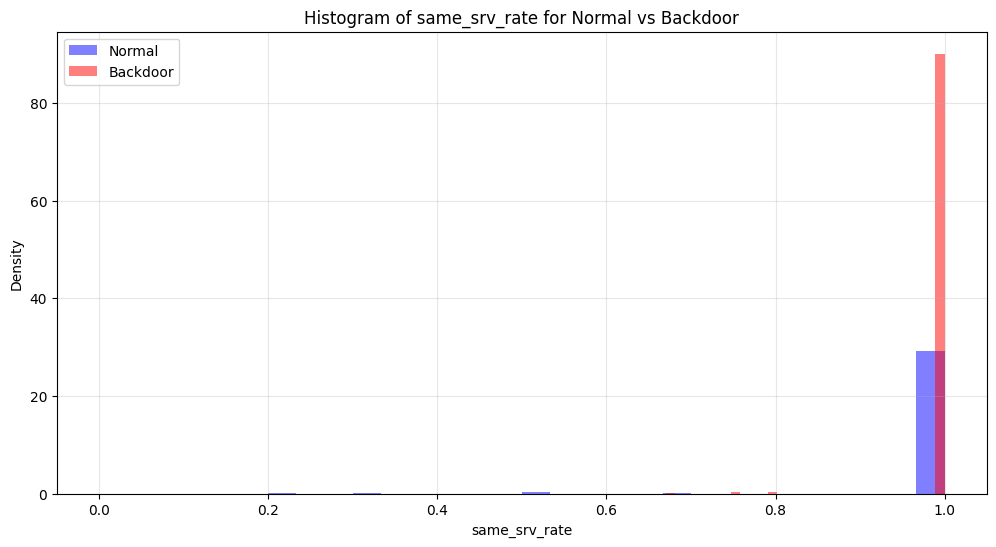

same_srv_rate: JS Divergence = 0.090018


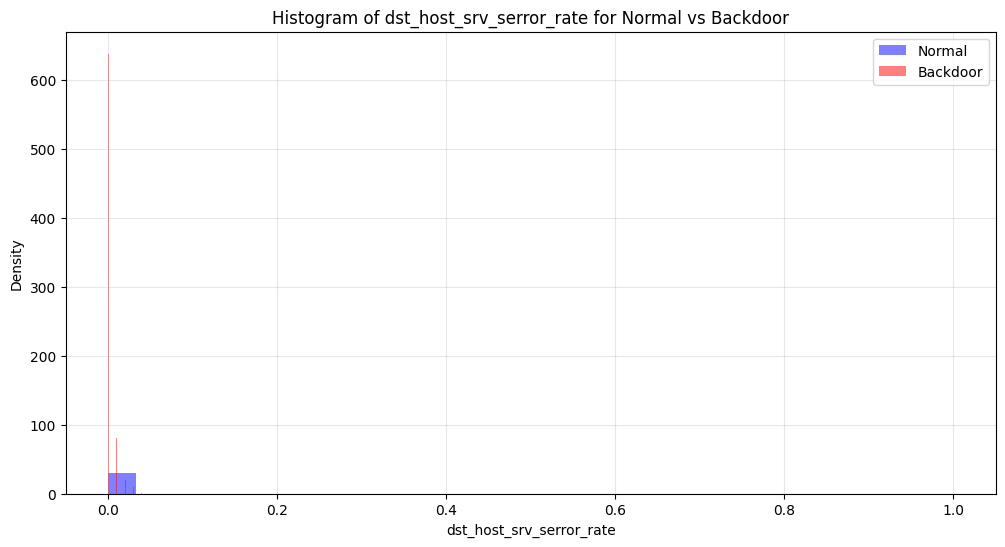

dst_host_srv_serror_rate: JS Divergence = 0.110319


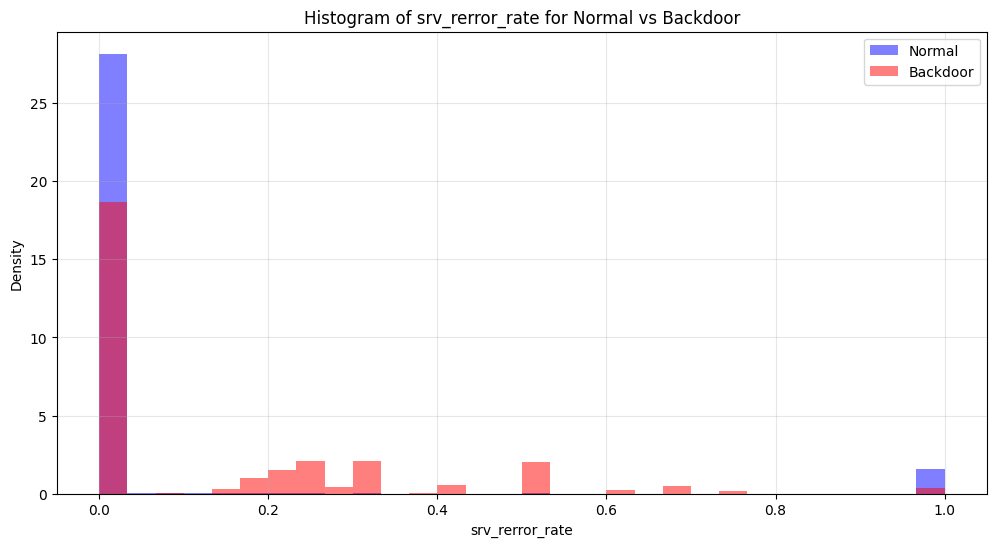

srv_rerror_rate: JS Divergence = 0.373477


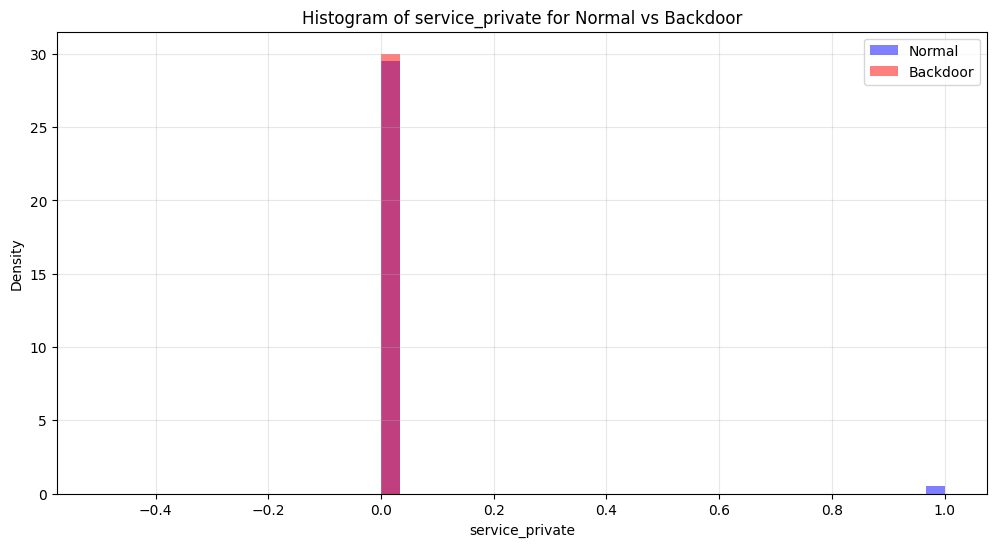

service_private: JS Divergence = 0.076209


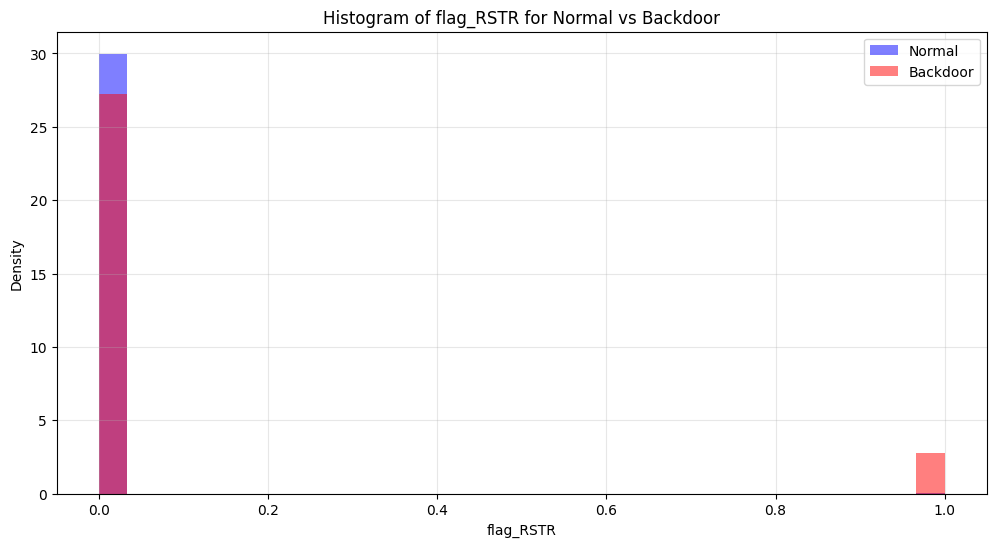

flag_RSTR: JS Divergence = 0.179750


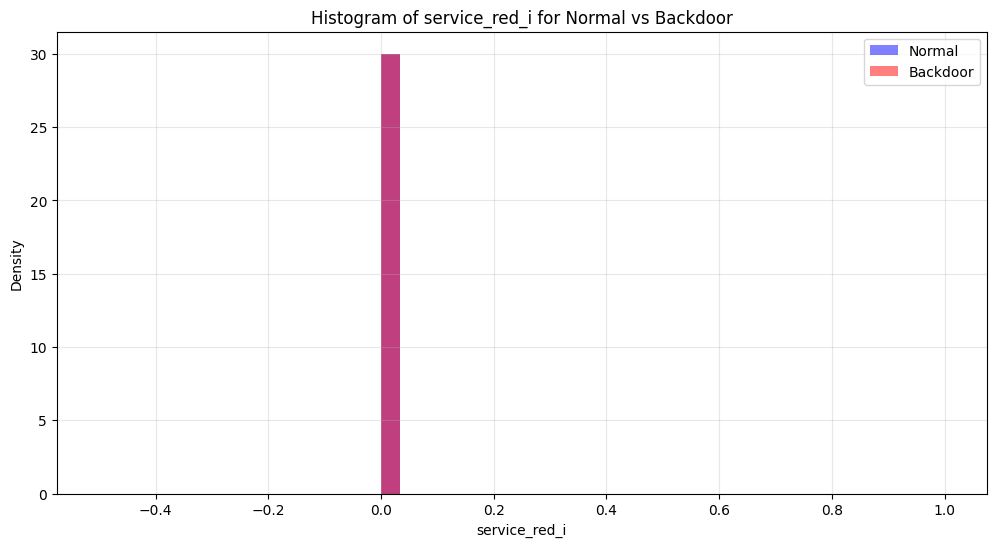

service_red_i: JS Divergence = 0.001986


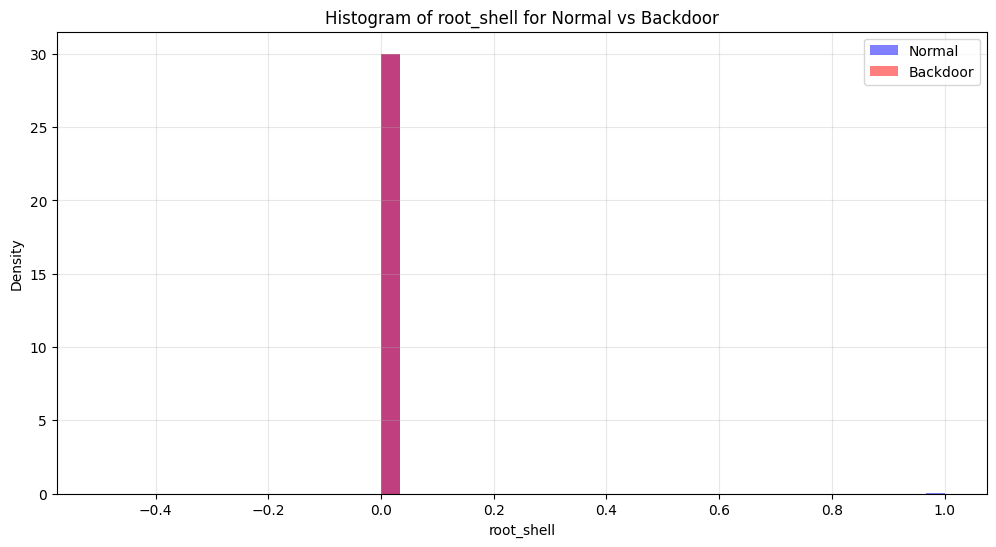

root_shell: JS Divergence = 0.009527


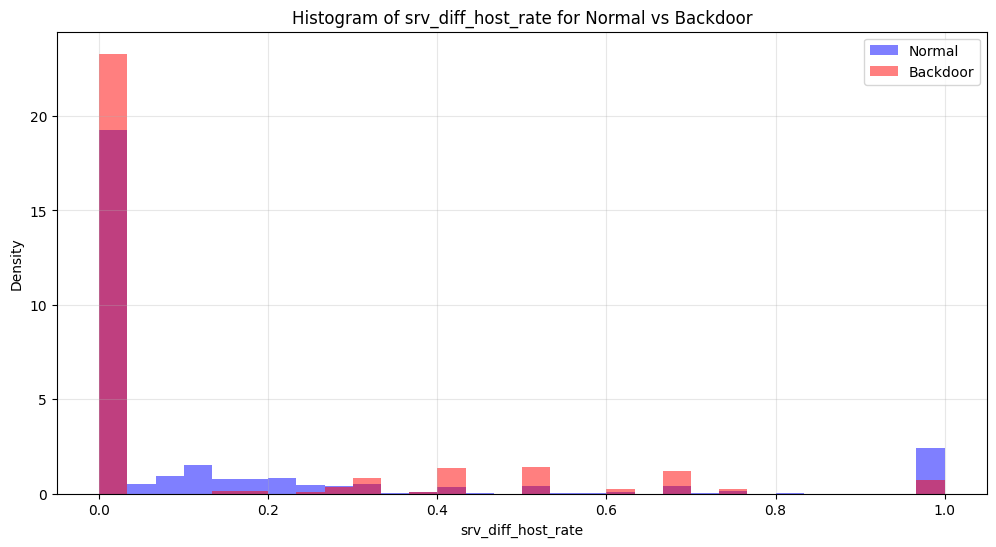

srv_diff_host_rate: JS Divergence = 0.285225


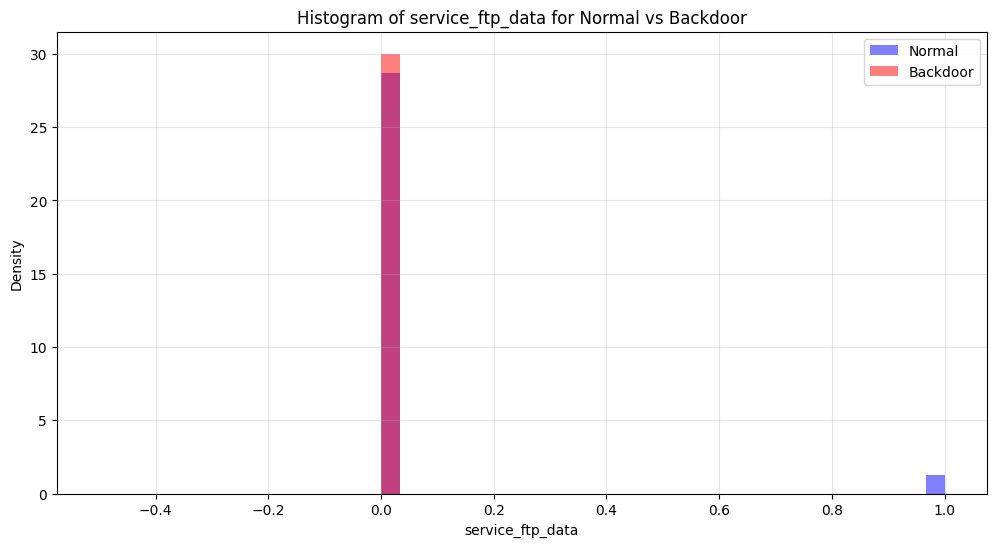

service_ftp_data: JS Divergence = 0.123374


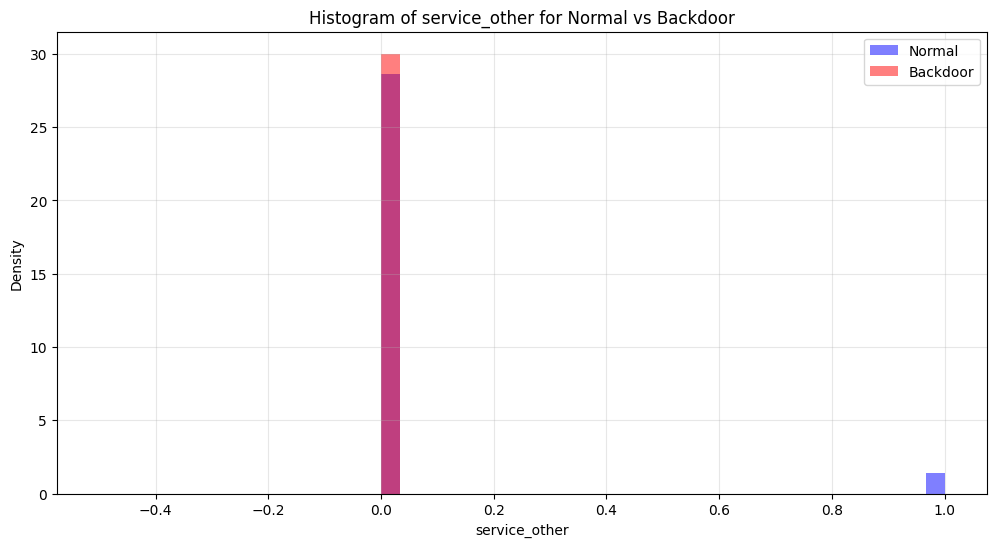

service_other: JS Divergence = 0.127246


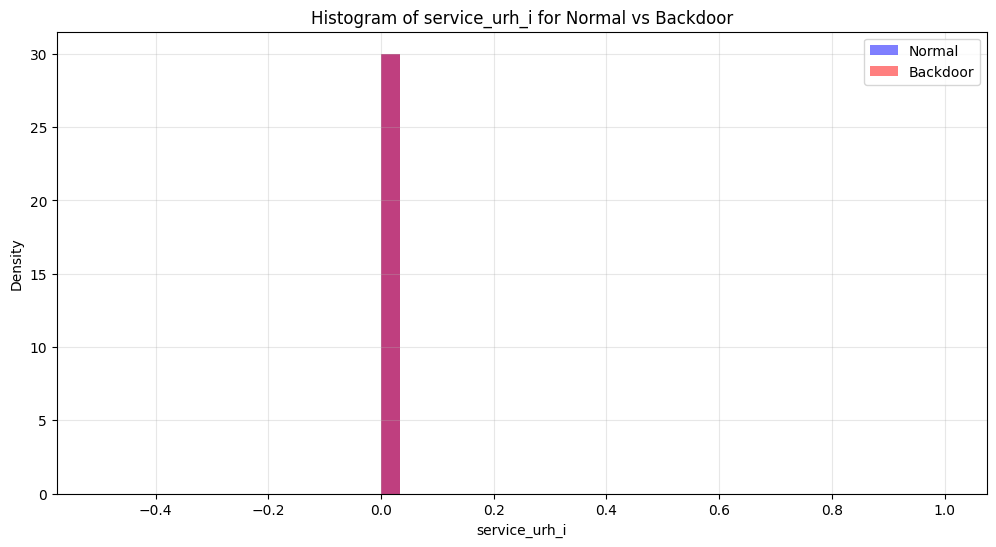

service_urh_i: JS Divergence = 0.007433


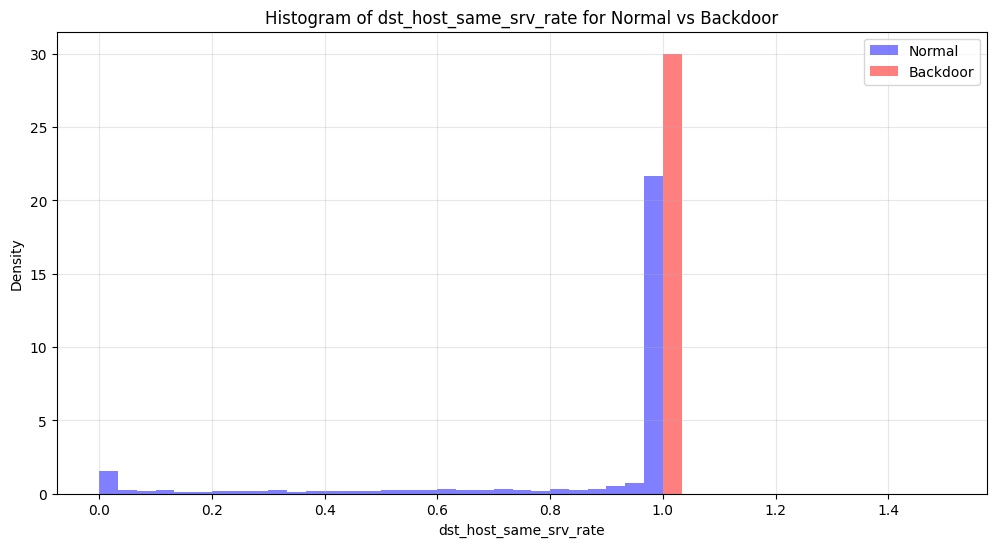

dst_host_same_srv_rate: JS Divergence = 0.344257


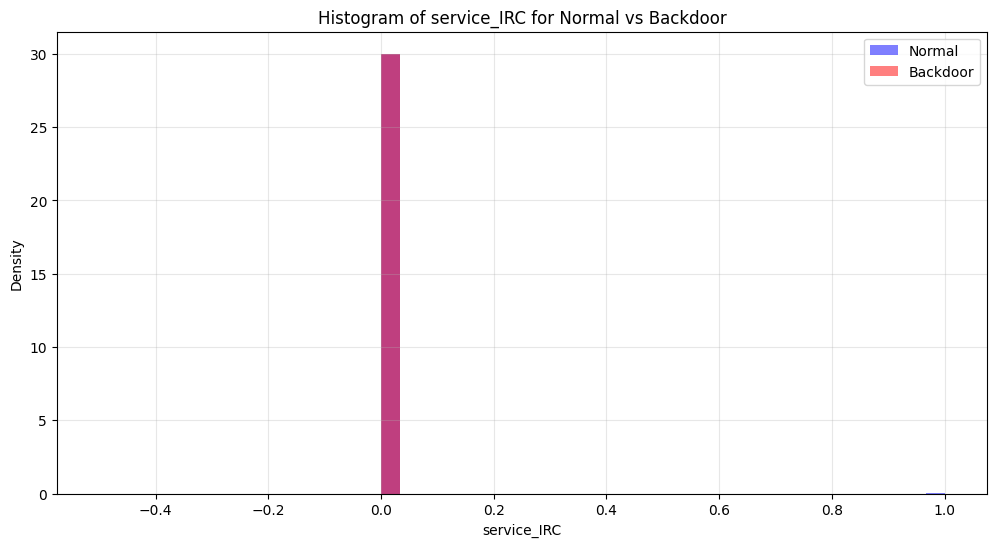

service_IRC: JS Divergence = 0.012875


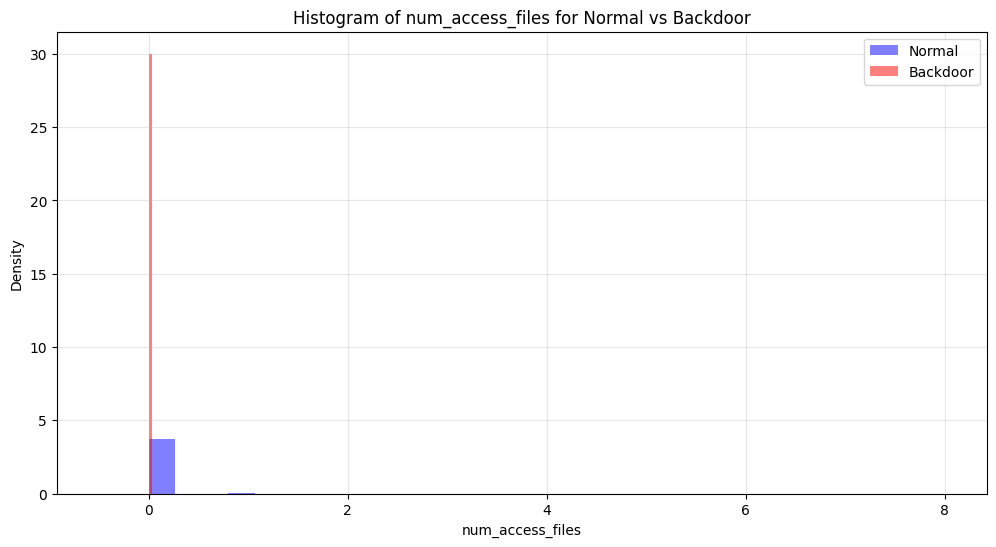

num_access_files: JS Divergence = 0.014816


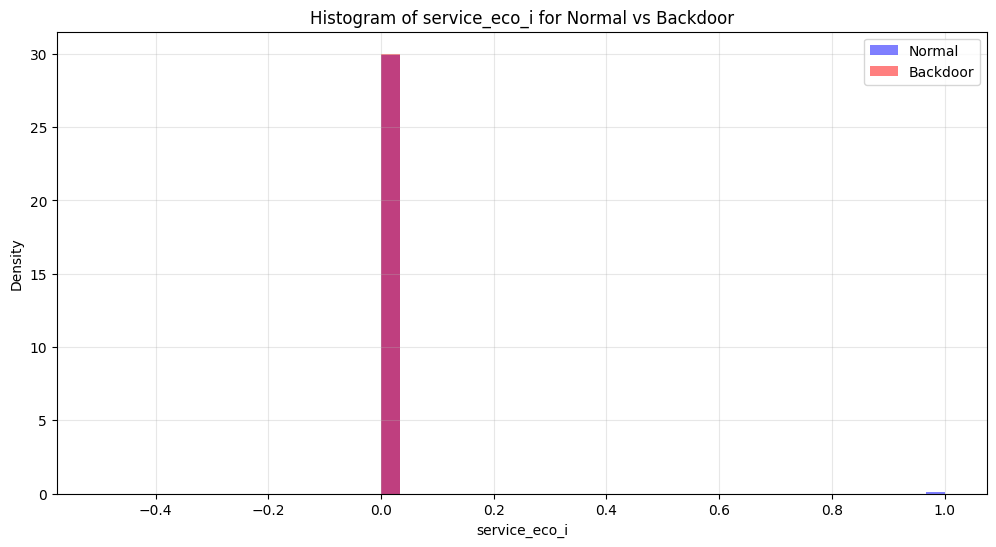

service_eco_i: JS Divergence = 0.031799


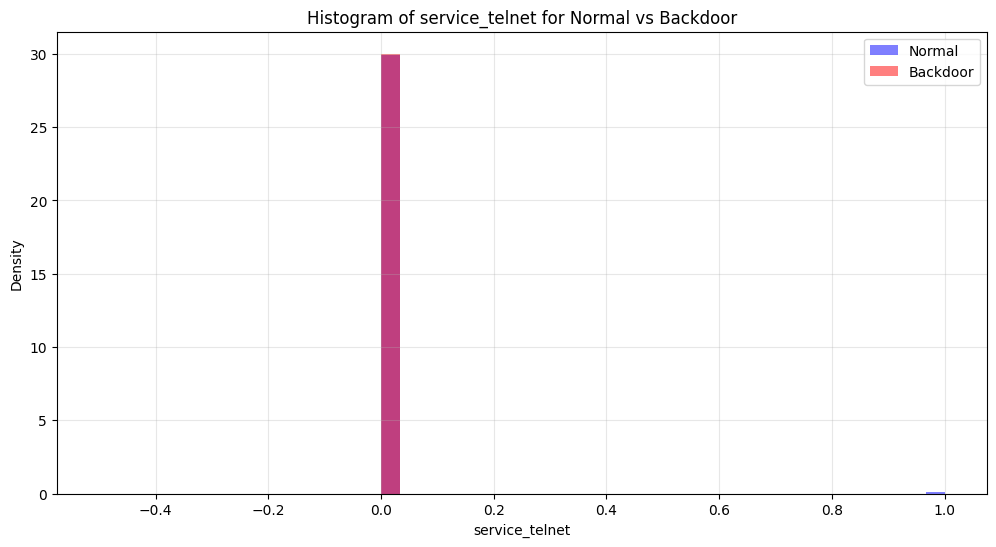

service_telnet: JS Divergence = 0.029410


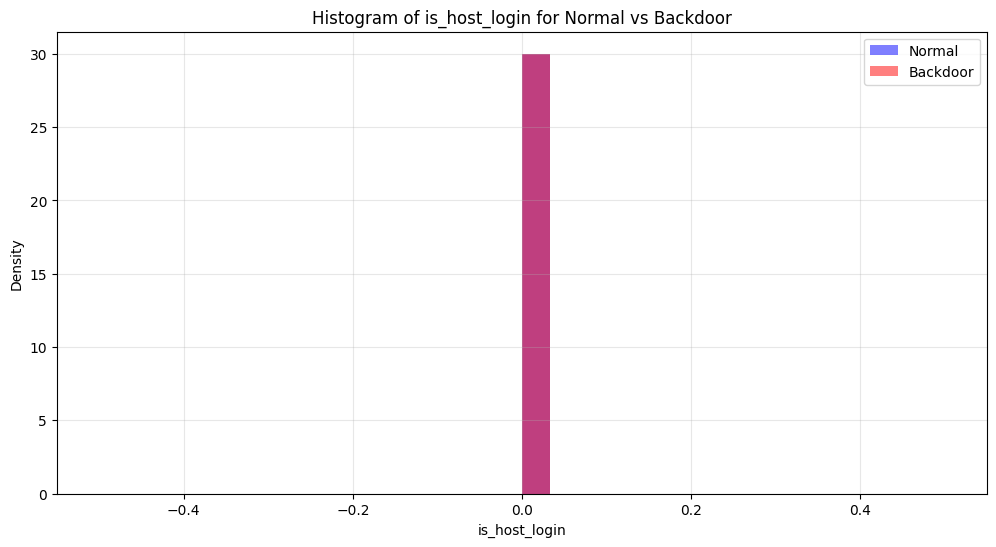

is_host_login: JS Divergence = nan


/tmp/ipython-input-2574431234.py:69: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(0.5 * (entropy(p, m) + entropy(q, m)))


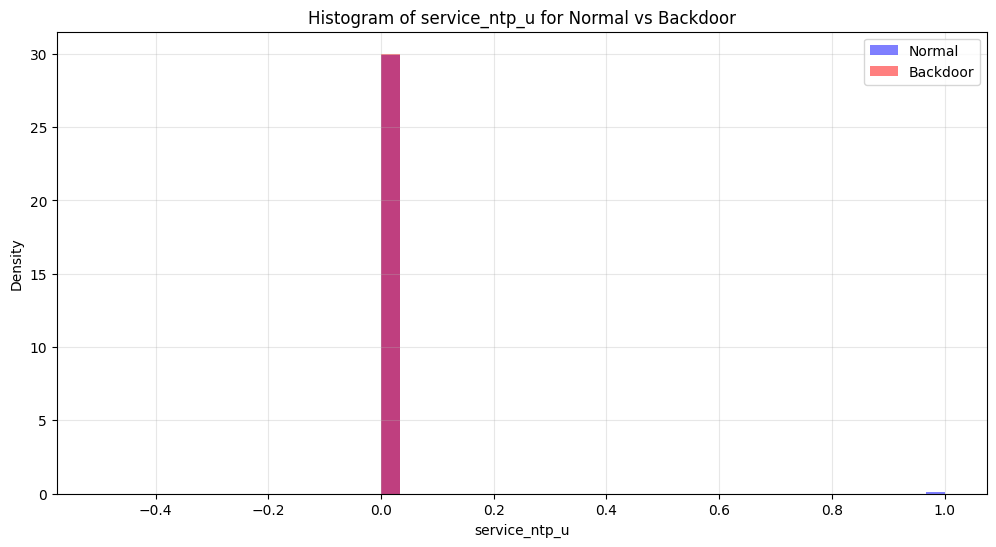

service_ntp_u: JS Divergence = 0.033848


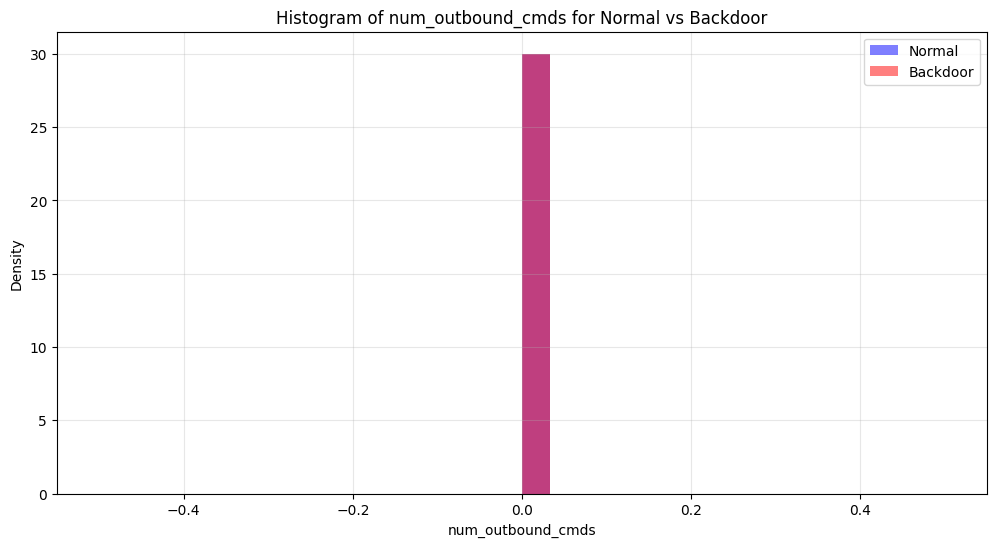

num_outbound_cmds: JS Divergence = nan


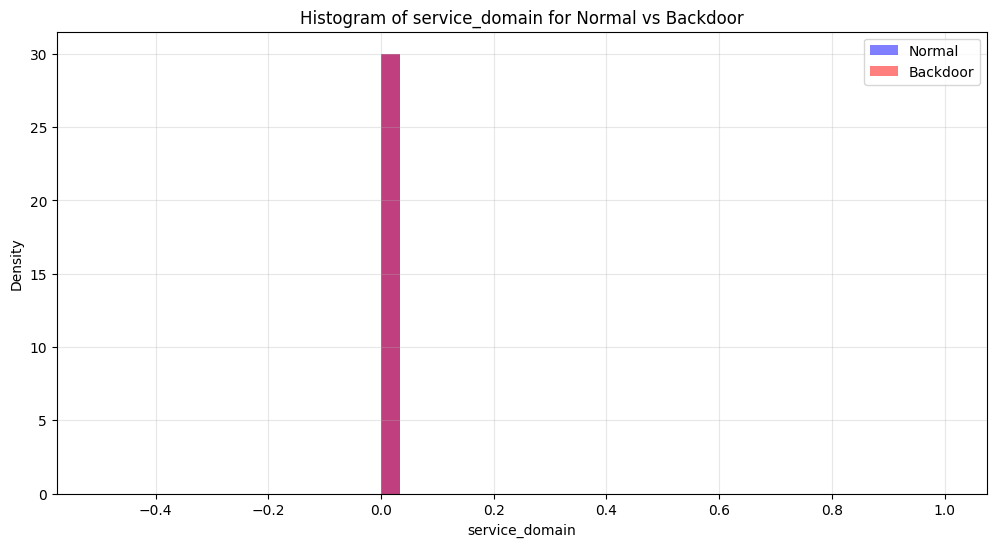

service_domain: JS Divergence = 0.003441


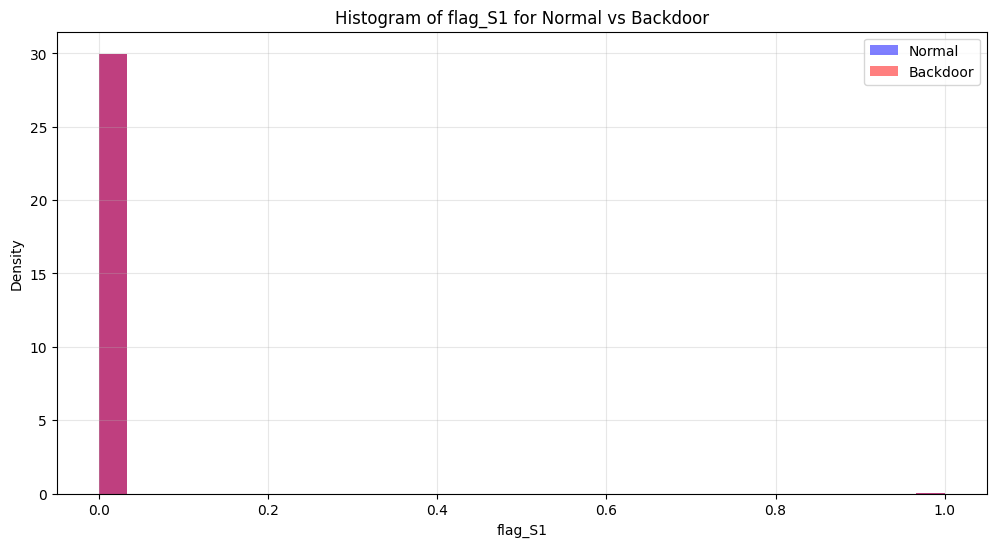

flag_S1: JS Divergence = 0.014409


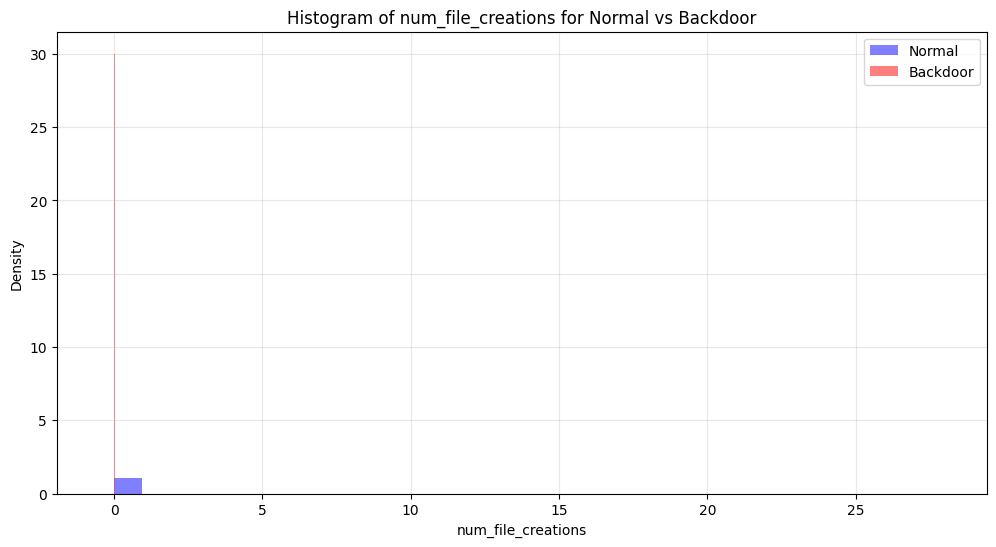

num_file_creations: JS Divergence = 0.005738


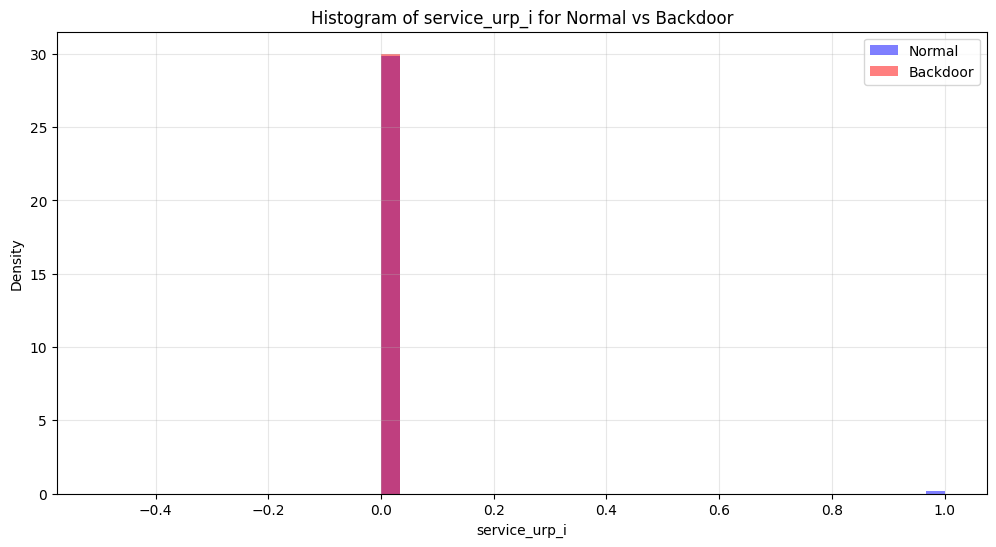

service_urp_i: JS Divergence = 0.041800


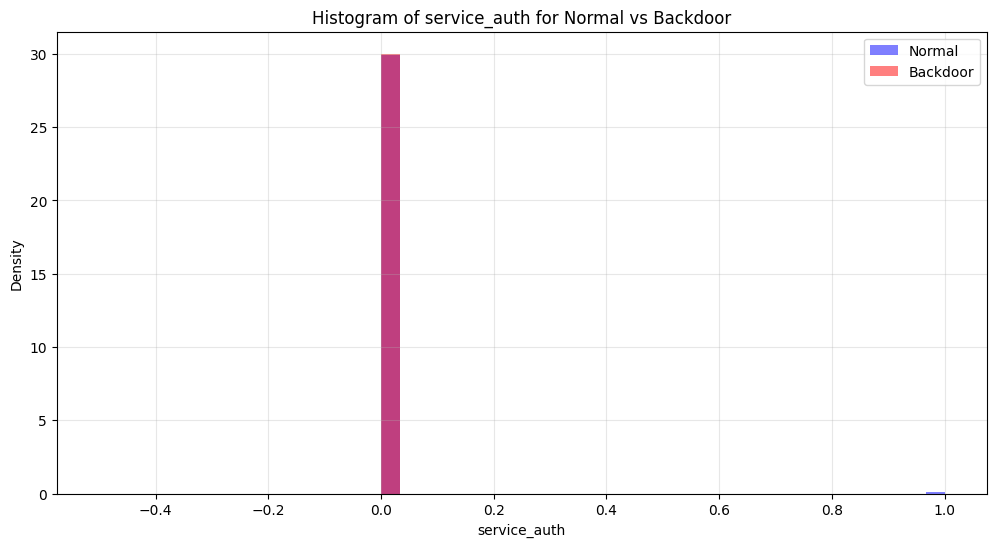

service_auth: JS Divergence = 0.029477


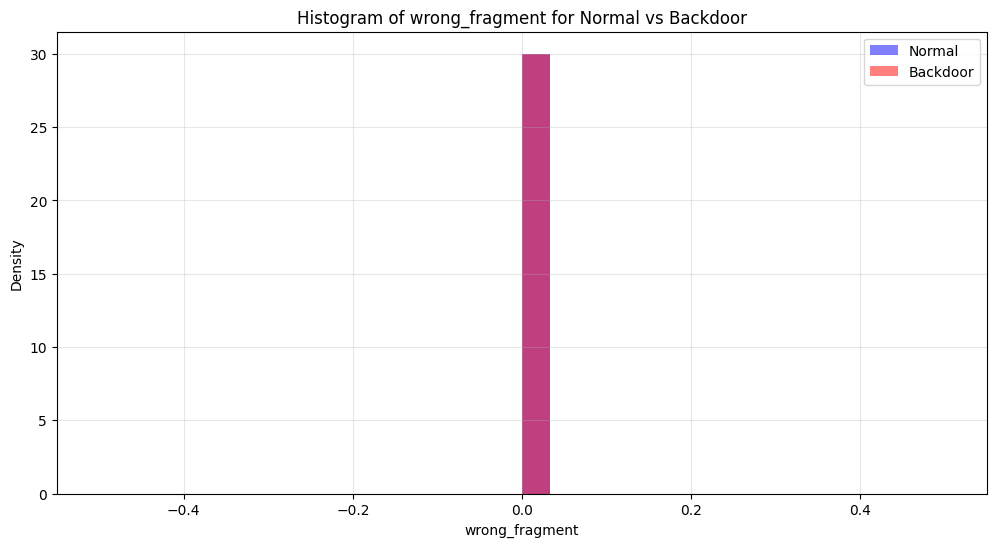

wrong_fragment: JS Divergence = nan


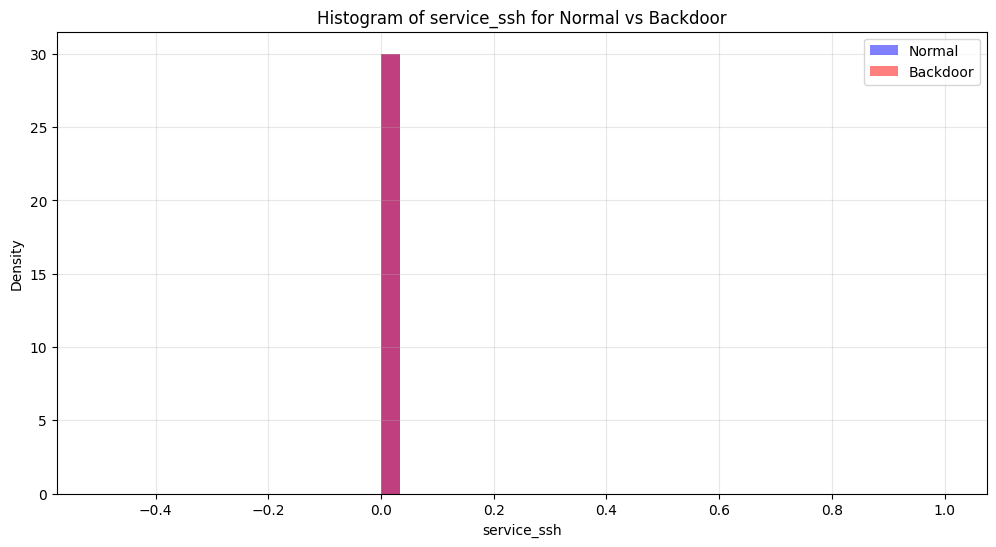

service_ssh: JS Divergence = 0.001986


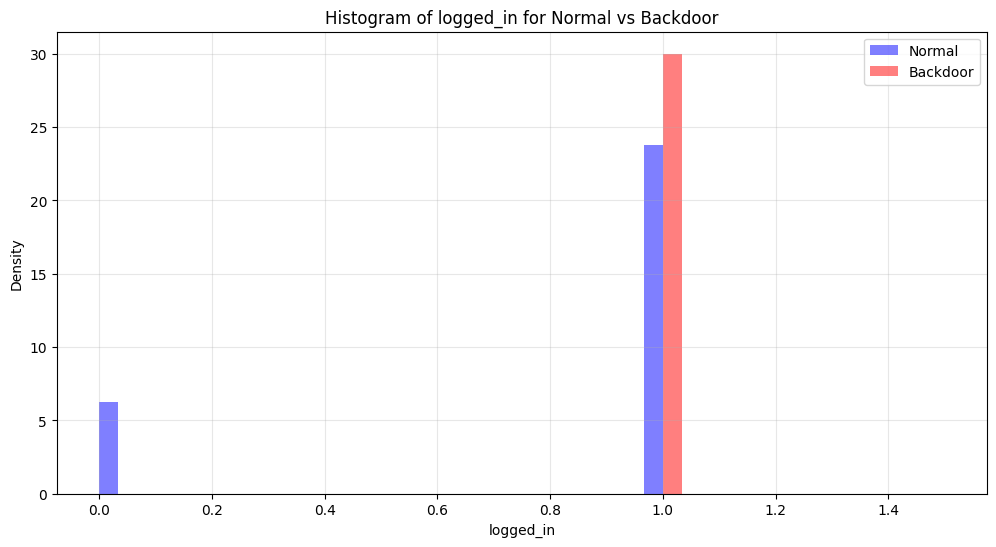

logged_in: JS Divergence = 0.279071


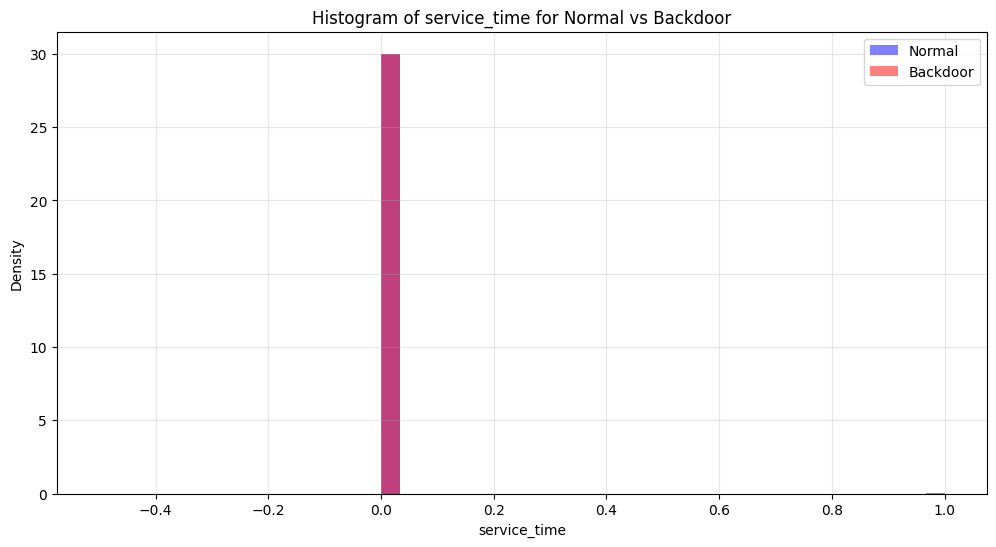

service_time: JS Divergence = 0.011753


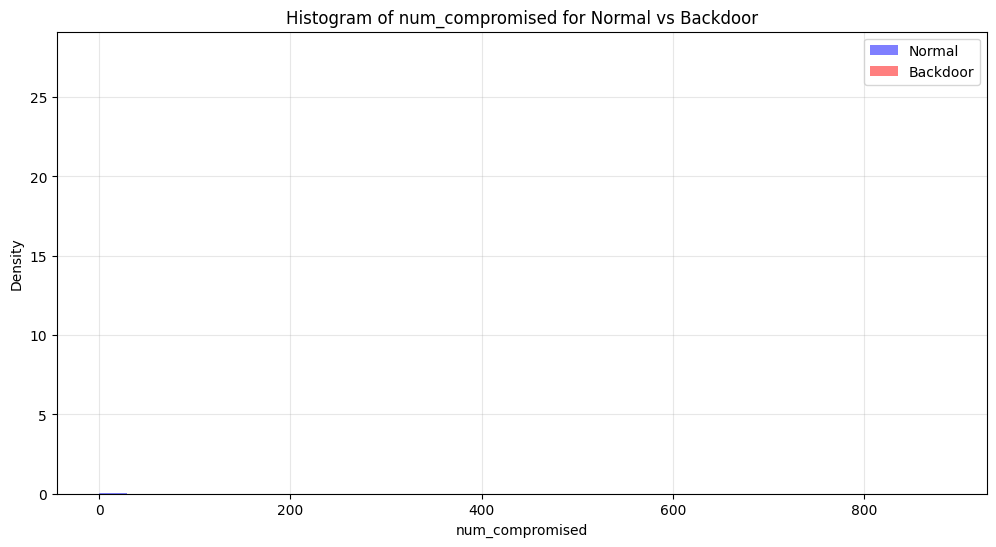

num_compromised: JS Divergence = 0.112573


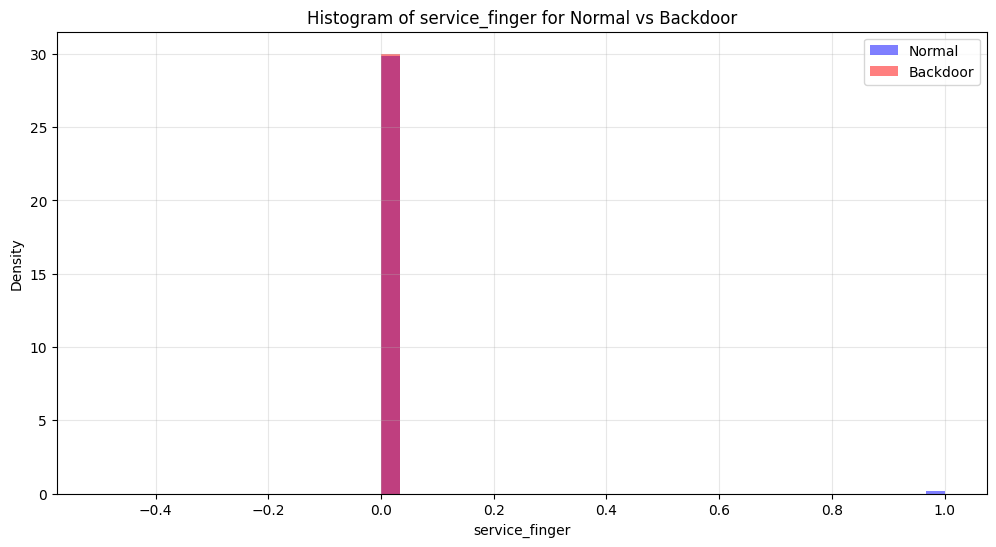

service_finger: JS Divergence = 0.043014


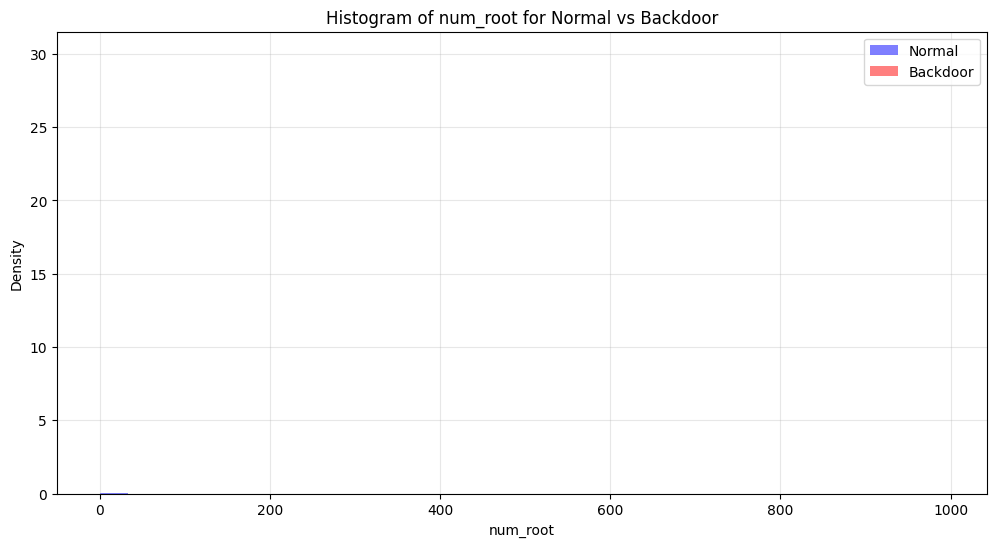

num_root: JS Divergence = 0.001521


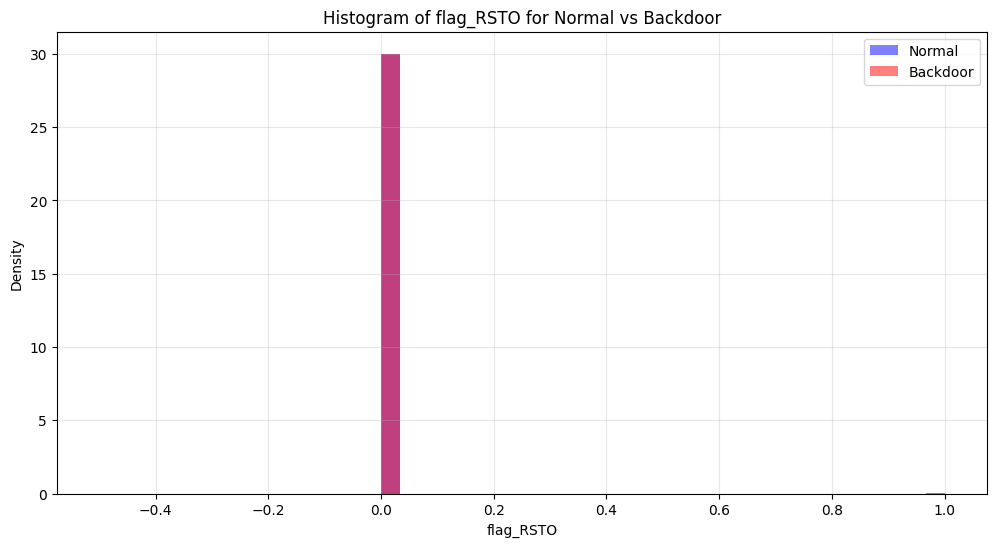

flag_RSTO: JS Divergence = 0.016140


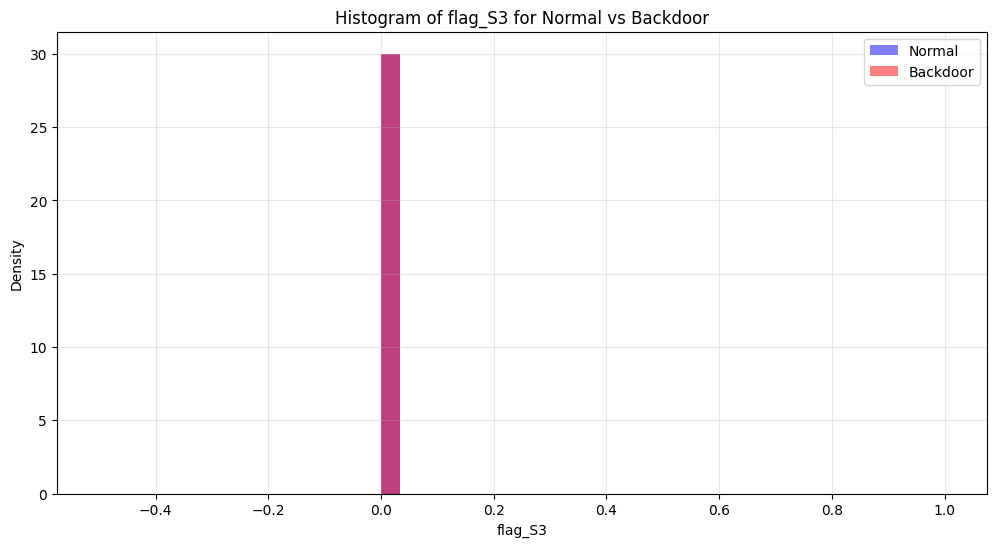

flag_S3: JS Divergence = 0.005256


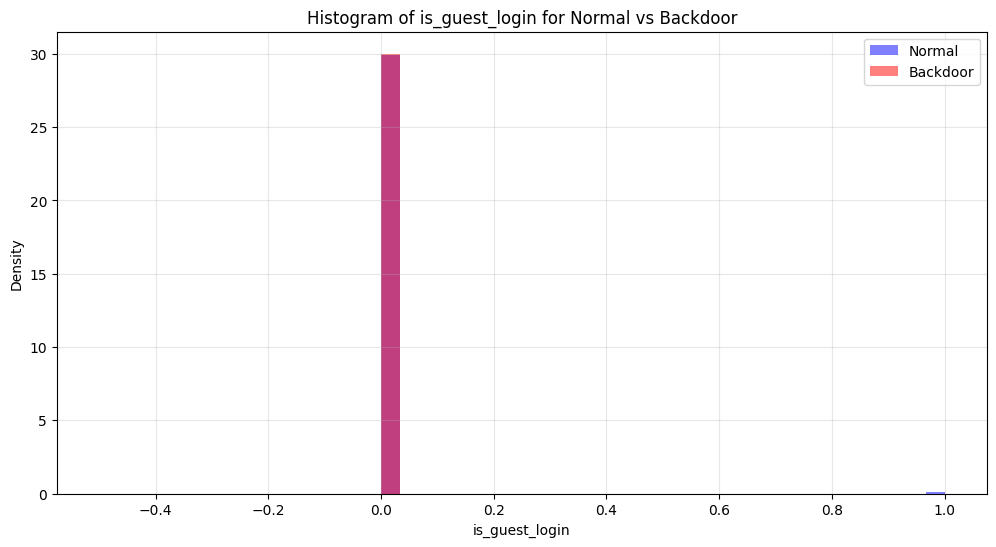

is_guest_login: JS Divergence = 0.038290


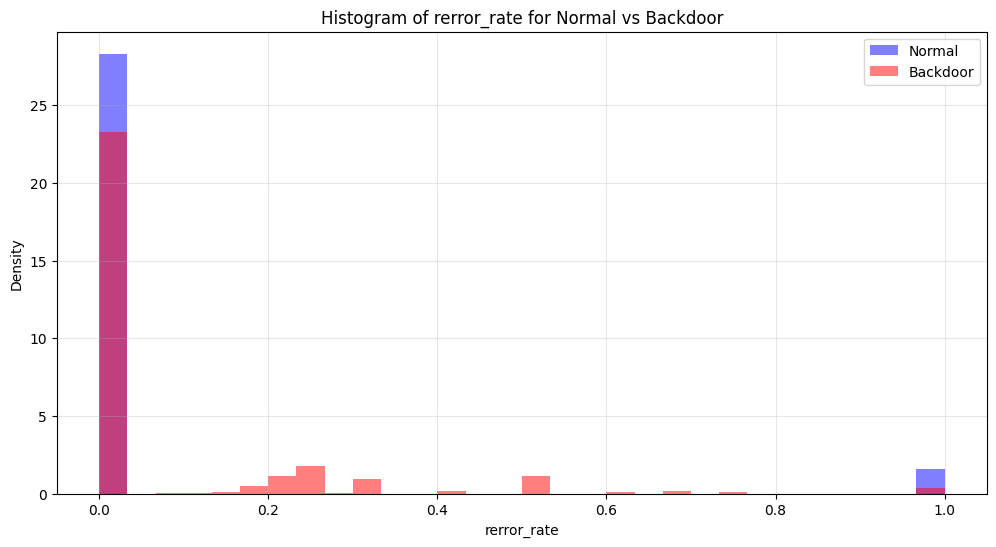

rerror_rate: JS Divergence = 0.284472


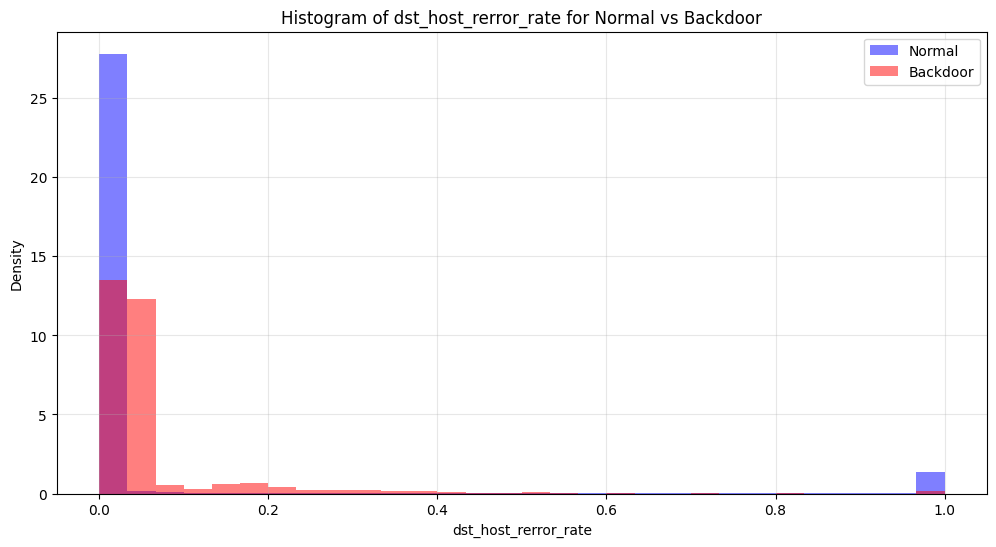

dst_host_rerror_rate: JS Divergence = 0.459732


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Use raw data from df_no_attacks and df_attacks
normal_df = df_no_attacks.select_dtypes(include=np.number)
backdoor_df = df_attacks.select_dtypes(include=np.number)

# Ensure both DataFrames have the same columns
common_cols = list(set(normal_df.columns) & set(backdoor_df.columns))
normal_df = normal_df[common_cols]
backdoor_df = backdoor_df[common_cols]

# Function to clean and optionally transform data
def clean_data(series, apply_log=False):
    # Replace inf/-inf with NaN
    series = series.replace([np.inf, -np.inf], np.nan)
    # Apply log transformation if specified (log(1 + x) to handle zeros)
    if apply_log:
        series = np.log1p(series)
    return series.dropna()

# Columns that typically need log transformation due to skewness in KDD Cup dataset
log_transform_columns = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

print("Jensen-Shannon Distance between normal and backdoor outcomes for each feature:")

# Plot histograms and compute Jensen-Shannon distance for each numerical feature
for column in common_cols:
    # Apply log transformation for skewed features
    apply_log = column in log_transform_columns
    normal_data = clean_data(normal_df[column], apply_log=apply_log)
    backdoor_data = clean_data(backdoor_df[column], apply_log=apply_log)

    # Check for sufficient data
    if len(normal_data) < 2 or len(backdoor_data) < 2:
        print(f"{column}: Cannot compute JS distance (insufficient data after cleaning)")
        continue

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.hist(normal_data, bins=30, alpha=0.5, label='Normal', density=True, color='blue')
    plt.hist(backdoor_data, bins=30, alpha=0.5, label='Backdoor', density=True, color='red')
    plt.title(f'Histogram of {column} for Normal vs Backdoor' + (' (log-transformed)' if apply_log else ''))
    plt.xlabel(column + (' (log scale)' if apply_log else ''))
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Compute histograms with unified bins
    all_bins = np.unique(np.concatenate((
        np.histogram_bin_edges(normal_data, bins=30),
        np.histogram_bin_edges(backdoor_data, bins=30)
    )))
    hist_normal, _ = np.histogram(normal_data, bins=all_bins, density=True)
    hist_backdoor, _ = np.histogram(backdoor_data, bins=all_bins, density=True)

    # Add epsilon to avoid log(0)
    epsilon = 1e-10
    hist_normal = hist_normal + epsilon
    hist_backdoor = hist_backdoor + epsilon

    # Calculate Jensen-Shannon distance
    def jensen_shannon_distance(p, q):
        p = np.asarray(p)
        q = np.asarray(q)
        m = (p + q) / 2
        return np.sqrt(0.5 * (entropy(p, m) + entropy(q, m)))

    js_dist = jensen_shannon_distance(hist_normal, hist_backdoor)
    print(f"{column}: JS Divergence = {js_dist:.6f}")